# Merge Dataframes

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import shap
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from itertools import combinations

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
meta = pd.read_csv("data/input/FlowRepository_FR-FCM-Z3FH_samplelog.csv")
meta.head()

immu = pd.read_csv("data/input/Immunome_Labor_Onset_BG-Immunome_Labor_Onset_BG%202-Export%20Statistics-241025_1628.csv")

,Plate,ID,GA,Stims,EGA,TL,Timepoint,Source Population,Source FCS File,Unique Population Name
0,Plate1,1,26,GMCSF,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_GMCSF.fcs,LiveLeukocytes
1,Plate1,1,26,IFNa,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_IFNa.fcs,LiveLeukocytes
2,Plate1,1,26,IL246,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_IL246.fcs,LiveLeukocytes
3,Plate1,1,26,LPS,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_LPS.fcs,LiveLeukocytes
4,Plate1,1,26,unstim,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_unstim.fcs,LiveLeukocytes


### Clean columns for merging

In [3]:
immu[['Plate', 'ID', 'GA', 'Stims']] = immu['file'].str.split('_', n=3, expand=True)
immu=immu[['Plate', 'ID', 'GA', 'Stims'] + [col for col in immu.columns if col not in ['Plate', 'ID', 'GA', 'Stims']]]
immu['Stims']=immu['Stims'].str.split('_').str[0]
immu=immu[immu.Plate!="Plate14"]
immu = immu.drop(columns=["CD19|Eu151Di___151Eu_p38|median", "CD56 (NK)|Dy161Di___161Dy_cPARP|median", "CD8|Dy161Di___161Dy_cPARP|median"])
immu[['ID','GA']]=immu[['ID','GA']].apply(pd.to_numeric)

In [4]:
meta.columns = ['Plate', 'ID', 'GA', 'Stims', 'EGA', 'TL', 'Timepoint', 'Source Population', 'Source FCS File', 'Unique Population Name']

In [5]:
bigdf=immu.merge(meta[['Plate','ID','GA','Stims','EGA','TL','Timepoint']])
bigdf = bigdf[~bigdf['file'].str.contains(r'-1\.fcs$', regex=True)]

In [21]:
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])

longdf.head()

,ID,GA,Stims,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
0,1,26,GMCSF,3.310,2.41,0.0,0.0996,0.0,0.0,1.380,...,1.020,0.846,0.000977,0.49,0.0504,0.00,0.0000,2.66,2.09,0.0455
1,1,26,IFNa,0.874,1.44,0.0,0.0000,0.0,0.0,1.020,...,0.935,0.746,0.000000,0.00,7.3700,5.81,0.0274,6.34,4.42,10.5000
2,1,26,IL246,0.896,1.94,0.0,0.4500,0.0,0.0,1.070,...,1.220,1.150,0.039800,22.40,57.3000,43.20,14.0000,33.90,29.50,44.5000
3,1,26,LPS,3.310,4.31,0.0,0.1900,0.0,0.0,2.870,...,1.060,0.854,0.591000,0.00,0.0000,0.00,0.0000,2.76,2.19,0.0000
4,1,26,unstim,0.977,1.26,0.0,0.0000,0.0,0.0,0.848,...,0.963,0.848,0.000000,0.00,0.0000,0.00,0.0000,2.48,1.93,0.0000


### Make table for each stim


In [8]:
stim_values = longdf['Stims'].unique()

# Create separate DataFrames for each unique Stim
stim_dfs = {stim: longdf[longdf['Stims'] == stim] for stim in stim_values}

GMCSF_df = stim_dfs['GMCSF']
IFNa_df = stim_dfs['IFNa']
IL246_df = stim_dfs['IL246']
LPS_df = stim_dfs['LPS']
unstim_df = stim_dfs['unstim']

### SHAP

In [19]:
stimulation=longdf.Stims.unique().tolist()
#%%

input=longdf[longdf.Stims==sti]
input = input.loc[:, input.nunique() > 1]

for sti in stimulation:
    seed = 18399
    patient=input.ID.unique().tolist()
    random.shuffle(patient)
    split_index = int(len(patient) * 0.85)
    train_patients = patient[:split_index]
    test_patients = patient[split_index:]
    train_df=input[input.ID.isin(train_patients)]
    test_df=input[input.ID.isin(test_patients)]
    X_train=train_df.drop(['ID','GA'],axis=1)
    X_test=test_df.drop(['ID','GA'],axis=1)
    y_train=train_df['GA']
    y_test=test_df['GA']
    xgb_model=XGBRegressor(n_estimators=110, learning_rate=0.1, max_depth=30, objective='reg:squarederror')
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    r_value = np.corrcoef(y_test, y_pred)[0, 1] 
    print(sti)
    print(f"Pearson R value: {r_value:.4f}")
    #shap table
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(np.array(X_test), check_additivity=False)
    ## Compute mean absolute SHAP values for each feature
    shap_importance = np.abs(shap_values).mean(axis=0)
    # Convert to DataFrame
    shap_df = pd.DataFrame({'Feature': X_test.columns, 'SHAP Importance': shap_importance, 'R Value': r_value, 'Stims': sti})
    # Save to CSV
    shap_df.to_csv(f'/data/output/shap_feature_importance_{sti}.csv', index=False)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

GMCSF
Pearson R value: 0.4695


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

IFNa
Pearson R value: 0.2325


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

IL246
Pearson R value: 0.1688


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

LPS
Pearson R value: -0.0641


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=110, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

unstim
Pearson R value: 0.4301


In [18]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(np.array(X_test), check_additivity=False)

shap_importance = np.abs(shap_values).mean(axis=0)

# Convert to DataFrame
shap_df = pd.DataFrame({'Feature': X_test.columns, 'SHAP Importance': shap_importance})
# Save to CSV
shap_df.to_csv("shap_feature_importance.csv", index=False)
print("SHAP values saved successfully to shap_feature_importance.csv!")

SHAP values saved successfully to shap_feature_importance.csv!


In [ ]:
#csv file
#feature, SHAP importance, R value, what stimulates it

### 2 Combinations

In [24]:
combinations_list = list(combinations(stimulation, 2))
for sti_com in combinations_list:
    sti1=sti_com[0]
    sti2=sti_com[1]

    input1=longdf[longdf.Stims==sti1]
    input1 = input1.loc[:, input1.nunique() > 1]
    input2=longdf[longdf.Stims==sti2]
    input2 = input2.loc[:, input2.nunique() > 1]

    input = input1.merge(input2, on=["ID", "GA"], suffixes=('_' + str(sti1), '_' + str(sti2)))
   
    seed = 18399
    patient=input.ID.unique().tolist()
    random.shuffle(patient)
    split_index = int(len(patient) * 0.85)
    train_patients = patient[:split_index]
    test_patients = patient[split_index:]

    train_df=input[input.ID.isin(train_patients)]
    test_df=input[input.ID.isin(test_patients)]

    X_train=train_df.drop(['ID','GA'],axis=1)
    X_test=test_df.drop(['ID','GA'],axis=1)
    y_train=train_df['GA']
    y_test=test_df['GA']

    # rf = RandomForestRegressor(n_estimators=120, random_state=42)
    # rf.fit(X_train, y_train)
    # y_pred = rf.predict(X_test)
    # r_value = np.corrcoef(y_test, y_pred)[0, 1]

    xgb_model=XGBRegressor(n_estimators=120, learning_rate=0.1, max_depth=30, objective='reg:squarederror')
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    r_value = np.corrcoef(y_test, y_pred)[0, 1]

    print(sti1 + "&" + sti2)
    print(f"Pearson R value: {r_value:.4f}")
    
    feature_stims = []

    for feature in X_test.columns:
        if feature.endswith(f'_{sti1}'):
            feature_stims.append(f'{sti1}')
        else:
            feature_stims.append(f'{sti2}')

    r_values = [r_value] * len(X_test.columns)

    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(np.array(X_test), check_additivity=False)
    shap_importance = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({'Feature': X_test.columns, 'SHAP Importance': shap_importance, 'R Value': r_value, 'Stims': feature_stims})
    shap_df.to_csv(f'shap_feature_importance_{sti1}_{sti2}.csv', index=False)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

GMCSF&IFNa
Pearson R value: 0.7682
X_test.columns length: 148
shap_importance length: 148
feature_stims length: 148


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

GMCSF&IL246
Pearson R value: 0.3867
X_test.columns length: 147
shap_importance length: 148
feature_stims length: 148


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

GMCSF&LPS
Pearson R value: 0.6638
X_test.columns length: 145
shap_importance length: 147
feature_stims length: 147


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

GMCSF&unstim
Pearson R value: 0.3606
X_test.columns length: 130
shap_importance length: 145
feature_stims length: 145


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

IFNa&IL246
Pearson R value: 0.8063
X_test.columns length: 157
shap_importance length: 130
feature_stims length: 130


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

IFNa&LPS
Pearson R value: 0.5227
X_test.columns length: 155
shap_importance length: 157
feature_stims length: 157


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

IFNa&unstim
Pearson R value: 0.7562
X_test.columns length: 140
shap_importance length: 155
feature_stims length: 155


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

IL246&LPS
Pearson R value: 0.3960
X_test.columns length: 154
shap_importance length: 140
feature_stims length: 140


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

IL246&unstim
Pearson R value: 0.3331
X_test.columns length: 139
shap_importance length: 154
feature_stims length: 154


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=120, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

LPS&unstim
Pearson R value: 0.2980
X_test.columns length: 137
shap_importance length: 139
feature_stims length: 139


### 3 Combinations

In [ ]:
combinations_list = list(combinations(stimulation, 3))
for sti_com in combinations_list:
    sti1=sti_com[0]
    sti2=sti_com[1]
    sti3=sti_com[2]

    input1=longdf[longdf.Stims==sti1]
    input1 = input1.loc[:, input1.nunique() > 1]
    input2=longdf[longdf.Stims==sti2]
    input2 = input2.loc[:, input2.nunique() > 1]
    input3=longdf[longdf.Stims==sti3]
    input3 = input3.loc[:, input3.nunique() > 1]
    
    input = input1.merge(input2, on=["ID", "GA"], suffixes=('_' + str(sti1), '_' + str(sti2))).merge(input3, on=["ID", "GA"])
   
    seed = 18399
    patient=input.ID.unique().tolist()
    random.shuffle(patient)
    split_index = int(len(patient) * 0.85)
    train_patients = patient[:split_index]
    test_patients = patient[split_index:]

    train_df=input[input.ID.isin(train_patients)]
    test_df=input[input.ID.isin(test_patients)]

    X_train=train_df.drop(['ID','GA'],axis=1)
    X_test=test_df.drop(['ID','GA'],axis=1)
    y_train=train_df['GA']
    y_test=test_df['GA']

    rf = RandomForestRegressor(n_estimators=120, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r_value = np.corrcoef(y_test, y_pred)[0, 1]

    print(sti1 + " & " + sti2 + " & " + sti3)
    print(f"Pearson R value: {r_value:.4f}")

### 4 Combinations

In [ ]:
combinations_list = list(combinations(stimulation, 4))
for sti_com in combinations_list:
    sti1=sti_com[0]
    sti2=sti_com[1]
    sti3=sti_com[2]
    sti4=sti_com[3]

    input1=longdf[longdf.Stims==sti1]
    input1 = input1.loc[:, input1.nunique() > 1]
    input2=longdf[longdf.Stims==sti2]
    input2 = input2.loc[:, input2.nunique() > 1]
    input3=longdf[longdf.Stims==sti3]
    input3 = input3.loc[:, input3.nunique() > 1]
    input4=longdf[longdf.Stims==sti4]
    input4 = input4.loc[:, input4.nunique() > 1]
    
    input = input1.merge(input2, on=["ID", "GA"], suffixes=('_' + str(sti1), '_' + str(sti2))).merge(input3, on=["ID", "GA"]).merge(input3, on=["ID", "GA"], suffixes=('_' + str(sti3), '_' + str(sti4)))
   
    seed = 18399
    patient=input.ID.unique().tolist()
    random.shuffle(patient)
    split_index = int(len(patient) * 0.85)
    train_patients = patient[:split_index]
    test_patients = patient[split_index:]

    train_df=input[input.ID.isin(train_patients)]
    test_df=input[input.ID.isin(test_patients)]

    X_train=train_df.drop(['ID','GA'],axis=1)
    X_test=test_df.drop(['ID','GA'],axis=1)
    y_train=train_df['GA']
    y_test=test_df['GA']

    rf = RandomForestRegressor(n_estimators=120, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r_value = np.corrcoef(y_test, y_pred)[0, 1]

    print(sti1 + " & " + sti2 + " & " + sti3+ " & " + sti4)
    print(f"Pearson R value: {r_value:.4f}")

### 5 Combinations

In [ ]:
combinations_list = list(combinations(stimulation, 5))
for sti_com in combinations_list:
    sti1=sti_com[0]
    sti2=sti_com[1]
    sti3=sti_com[2]
    sti4=sti_com[3]
    sti5=sti_com[4]

    input1=longdf[longdf.Stims==sti1]
    input1 = input1.loc[:, input1.nunique() > 1]
    input2=longdf[longdf.Stims==sti2]
    input2 = input2.loc[:, input2.nunique() > 1]
    input3=longdf[longdf.Stims==sti3]
    input3 = input3.loc[:, input3.nunique() > 1]
    input4=longdf[longdf.Stims==sti4]
    input4 = input4.loc[:, input4.nunique() > 1]
    input5=longdf[longdf.Stims==sti5]
    input5 = input5.loc[:, input5.nunique() > 1]
    
    input = input1.merge(input2, on=["ID", "GA"], suffixes=('_' + str(sti1), '_' + str(sti2))).merge(input3, on=["ID", "GA"]).merge(input3, on=["ID", "GA"], suffixes=('_' + str(sti3), '_' + str(sti4))).merge(input5, on=["ID", "GA"])
   
    seed = 18399
    patient=input.ID.unique().tolist()
    random.shuffle(patient)
    split_index = int(len(patient) * 0.85)
    train_patients = patient[:split_index]
    test_patients = patient[split_index:]

    train_df=input[input.ID.isin(train_patients)]
    test_df=input[input.ID.isin(test_patients)]

    X_train=train_df.drop(['ID','GA'],axis=1)
    X_test=test_df.drop(['ID','GA'],axis=1)
    y_train=train_df['GA']
    y_test=test_df['GA']

    rf = RandomForestRegressor(n_estimators=120, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r_value = np.corrcoef(y_test, y_pred)[0, 1]

    print(f"Pearson R value: {r_value:.4f}")

RandomForestRegressor(n_estimators=110, random_state=42)

Accuracy: 92.73


<Figure size 600x600 with 0 Axes>

Text(0.5, 0, 'Actual Values (y_test)')

Text(0, 0.5, 'Predicted Values (y_pred)')

Text(0.5, 1.0, 'Actual vs Predicted Values')

(22.0, 40.0)

(22.0, 40.0)

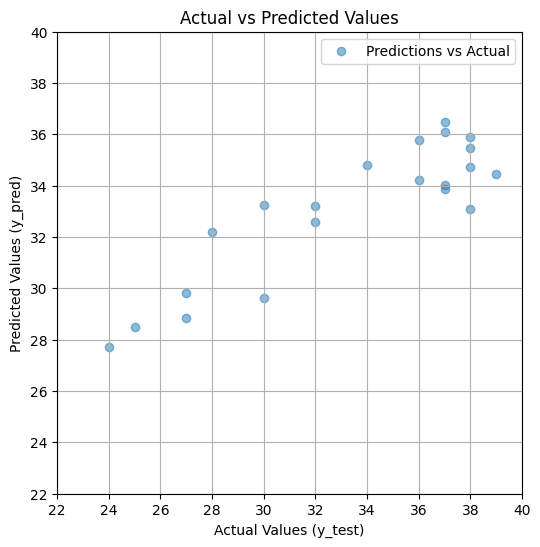

In [27]:
#%%
import pandas as pd
import numpy as np
import os
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from itertools import combinations
from functools import reduce
from sklearn import metrics

# %%
meta=pd.read_csv("data/input/FlowRepository_FR-FCM-Z3FH_samplelog.csv")
immu=pd.read_csv("data/input/Immunome_Labor_Onset_BG-Immunome_Labor_Onset_BG%202-Export%20Statistics-241025_1628.csv")

#%%
immu[['Plate', 'ID', 'GA', 'Stims']] = immu['file'].str.split('_', n=3, expand=True)
immu=immu[['Plate', 'ID', 'GA', 'Stims'] + [col for col in immu.columns if col not in ['Plate', 'ID', 'GA', 'Stims']]]
immu['Stims']=immu['Stims'].str.split('_').str[0]
immu=immu[immu.Plate!="Plate14"]
immu = immu.drop(columns=["CD19|Eu151Di___151Eu_p38|median", "CD56 (NK)|Dy161Di___161Dy_cPARP|median", "CD8|Dy161Di___161Dy_cPARP|median"])
immu[['ID','GA']]=immu[['ID','GA']].apply(pd.to_numeric)

#%%
meta.columns = ['Plate', 'ID', 'GA', 'Stims', 'EGA', 'TL', 'Timepoint', 'Source Population', 'Source FCS File', 'Unique Population Name']

#%%
bigdf=immu.merge(meta[['Plate','ID','GA','Stims','EGA','TL','Timepoint']])
bigdf = bigdf[~bigdf['file'].str.contains(r'-1\.fcs$', regex=True)]
# %%
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
stimulation=longdf.Stims.unique().tolist()

#%%
sti1='GMCSF'
sti2='IFNa'
sti3='unstim'

input1=longdf[longdf.Stims==sti1]
input1 = input1.loc[:, input1.nunique() > 1]
input2=longdf[longdf.Stims==sti2]
input2 = input2.loc[:, input2.nunique() > 1]
input3=longdf[longdf.Stims==sti3]
input3 = input3.loc[:, input3.nunique() > 1]

input = input1.merge(input2, on=["ID", "GA"], suffixes=('_' + str(sti1), '_' + str(sti2))).merge(input3, on=["ID", "GA"])

perm_imp_df=pd.read_csv('data/output/GMCSF & IFNa & unstim_RF_perm_ftimportance.csv')
selectft=perm_imp_df[perm_imp_df['Permutation Importance']>10**(-3)].Feature.tolist()
input=input[["ID", "GA"] + selectft]

#%%
random.seed(18399)
patient=input.ID.unique().tolist()
random.shuffle(patient)
split_index = int(len(patient) * 0.85)
train_patients = patient[:split_index]
test_patients = patient[split_index:]

train_df=input[input.ID.isin(train_patients)]
test_df=input[input.ID.isin(test_patients)]

X_train=train_df.drop(['ID','GA'],axis=1)
X_test=test_df.drop(['ID','GA'],axis=1)
y_train=train_df['GA']
y_test=test_df['GA']

#%%
rf = RandomForestRegressor(n_estimators=110, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2=metrics.r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
print('Accuracy:', round(100*(1 - mape), 2))
# %%
import matplotlib.pyplot as plt
# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions vs Actual")


# Labels and title
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs Predicted Values")
plt.xlim(22, 40)
plt.ylim(22, 40)
plt.legend()
plt.grid(True)

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': X_test.columns, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)


# Show plot
plt.show()

# %%

In [31]:
pip install StandardScaler

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.7 MB/s eta 0:00:00
  Created wheel for StandardScaler: filename=StandardScaler-0.5-py3-none-any.whl size=2648 sha256=9d66506b0865c605b51325018f067b72b6327d217c9763b26cb35d110573d186
  Stored in directory: /Users/wendysu0/Library/Caches/pip/wheels/fe/cf/ba/03416e6fb72a0105069c33d9bf5a2ec1af9a41fe57fa7ec554
Successfully built StandardScaler
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


Immune type UMAP

In [10]:
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
longdf.head()

meta_cols = longdf[["GA", "Stims"]]  # Adjust these to your actual metadata column names
meta_cols.head()
features = longdf.drop(columns=meta_cols)
features = features.drop(columns='ID')
features.head()

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Add UMAP results back to DataFrame
longdf["UMAP1"] = embedding[:, 0]
longdf["UMAP2"] = embedding[:, 1]

# Plot UMAP
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue=longdf["Stims"],  # Color by stimulus
    #style=longdf["GA"],  # Different markers for gestational age
    palette="viridis",  # Adjust as needed
    data=longdf,
    alpha=0.8
)

ax.legend(title="Stimulus Type")  # Set title for the hue legend

# Add plot title
plt.title("UMAP of Immune Profiles by Stimulus")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

,ID,GA,Stims,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
0,1,26,GMCSF,3.310,2.41,0.0,0.0996,0.0,0.0,1.380,...,1.020,0.846,0.000977,0.49,0.0504,0.00,0.0000,2.66,2.09,0.0455
1,1,26,IFNa,0.874,1.44,0.0,0.0000,0.0,0.0,1.020,...,0.935,0.746,0.000000,0.00,7.3700,5.81,0.0274,6.34,4.42,10.5000
2,1,26,IL246,0.896,1.94,0.0,0.4500,0.0,0.0,1.070,...,1.220,1.150,0.039800,22.40,57.3000,43.20,14.0000,33.90,29.50,44.5000
3,1,26,LPS,3.310,4.31,0.0,0.1900,0.0,0.0,2.870,...,1.060,0.854,0.591000,0.00,0.0000,0.00,0.0000,2.76,2.19,0.0000
4,1,26,unstim,0.977,1.26,0.0,0.0000,0.0,0.0,0.848,...,0.963,0.848,0.000000,0.00,0.0000,0.00,0.0000,2.48,1.93,0.0000


,GA,Stims
0,26,GMCSF
1,26,IFNa
2,26,IL246
3,26,LPS
4,26,unstim


,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,Neutrophils/Neutrophils|Nd150Di___150Nd_STAT5|median,CD14 (Monocytes)|Nd150Di___150Nd_STAT5|median,CD19|Nd150Di___150Nd_STAT5|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
0,3.310,2.41,0.0,0.0996,0.0,0.0,1.380,35.400,17.300,0.00,...,1.020,0.846,0.000977,0.49,0.0504,0.00,0.0000,2.66,2.09,0.0455
1,0.874,1.44,0.0,0.0000,0.0,0.0,1.020,7.120,15.600,4.97,...,0.935,0.746,0.000000,0.00,7.3700,5.81,0.0274,6.34,4.42,10.5000
2,0.896,1.94,0.0,0.4500,0.0,0.0,1.070,2.740,2.540,1.68,...,1.220,1.150,0.039800,22.40,57.3000,43.20,14.0000,33.90,29.50,44.5000
3,3.310,4.31,0.0,0.1900,0.0,0.0,2.870,0.892,0.554,0.00,...,1.060,0.854,0.591000,0.00,0.0000,0.00,0.0000,2.76,2.19,0.0000
4,0.977,1.26,0.0,0.0000,0.0,0.0,0.848,0.886,0.515,0.00,...,0.963,0.848,0.000000,0.00,0.0000,0.00,0.0000,2.48,1.93,0.0000


In [23]:
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
longdf = longdf[longdf['Stims'] == 'unstim']
longdf.head()

meta_cols = longdf[["GA", "Stims"]]  # Adjust these to your actual metadata column names
meta_cols.head()
features = longdf.drop(columns=meta_cols)
features = features.drop(columns='ID')
features.head()



,ID,GA,Stims,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
4,1,26,unstim,0.977,1.26,0.0,0.000,0.0,0.0000,0.848,...,0.963,0.848,0.0,0.0,0.0,0.0,0.0,2.48,1.93,0.0
9,1,33,unstim,0.773,1.01,0.0,0.000,0.0,0.0000,0.737,...,0.931,0.749,0.0,0.0,0.0,0.0,0.0,2.55,1.96,0.0
14,1,35,unstim,1.660,1.48,0.0,0.171,0.0,0.0000,1.160,...,1.080,0.772,0.0,0.0,0.0,0.0,0.0,2.78,1.98,0.0
19,3,25,unstim,1.430,1.71,0.0,0.655,0.0,0.0481,1.530,...,1.520,1.270,0.0,0.0,0.0,0.0,0.0,3.41,2.86,0.0
24,3,30,unstim,1.970,1.87,0.0,0.378,0.0,0.0000,1.480,...,1.560,1.250,0.0,0.0,0.0,0.0,0.0,3.46,2.99,0.0


,GA,Stims
4,26,unstim
9,33,unstim
14,35,unstim
19,25,unstim
24,30,unstim


,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,Neutrophils/Neutrophils|Nd150Di___150Nd_STAT5|median,CD14 (Monocytes)|Nd150Di___150Nd_STAT5|median,CD19|Nd150Di___150Nd_STAT5|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
4,0.977,1.26,0.0,0.000,0.0,0.0000,0.848,0.886,0.515,0.0,...,0.963,0.848,0.0,0.0,0.0,0.0,0.0,2.48,1.93,0.0
9,0.773,1.01,0.0,0.000,0.0,0.0000,0.737,0.670,0.464,0.0,...,0.931,0.749,0.0,0.0,0.0,0.0,0.0,2.55,1.96,0.0
14,1.660,1.48,0.0,0.171,0.0,0.0000,1.160,0.821,0.514,0.0,...,1.080,0.772,0.0,0.0,0.0,0.0,0.0,2.78,1.98,0.0
19,1.430,1.71,0.0,0.655,0.0,0.0481,1.530,1.090,0.719,0.0,...,1.520,1.270,0.0,0.0,0.0,0.0,0.0,3.41,2.86,0.0
24,1.970,1.87,0.0,0.378,0.0,0.0000,1.480,1.010,0.725,0.0,...,1.560,1.250,0.0,0.0,0.0,0.0,0.0,3.46,2.99,0.0


/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'UMAP of Immune Profiles by Gestational Age')

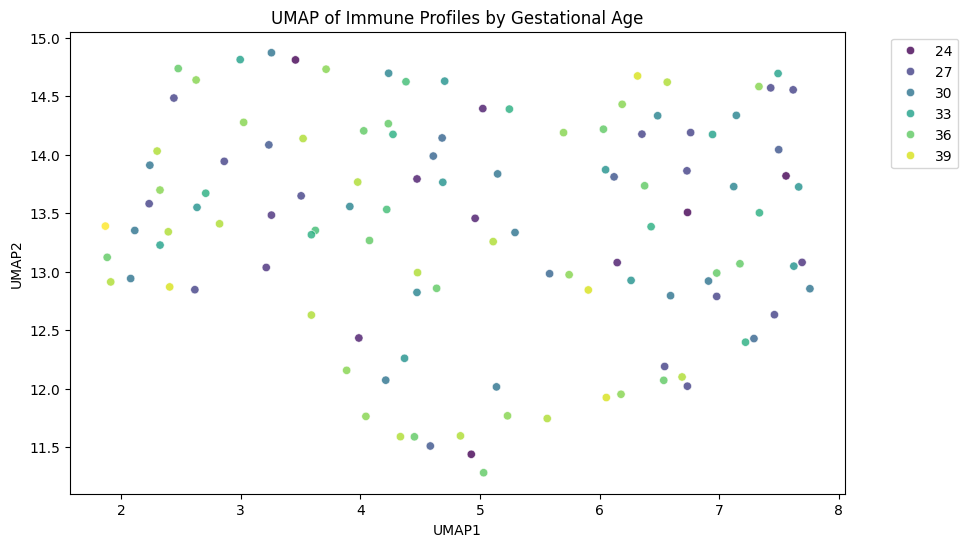

In [ ]:
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Add UMAP results back to DataFrame
longdf["UMAP1"] = embedding[:, 0]
longdf["UMAP2"] = embedding[:, 1]

# Plot UMAP
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue=longdf["GA"],  # Color by stimulus
    #style=longdf["GA"],  # Different markers for gestational age
    palette="viridis",  # Adjust as needed
    data=longdf,
    alpha=0.8
)

ax.legend(title="Gestational Age")  # Set title for the hue legend

# Add plot title
plt.title("UMAP of Immune Profiles by Gestational Age")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("feature_importance.png")

plt.show()

Feature Importance

,Feature,Permutation Importance
0,CD56 (NK)|Eu153Di___153Eu_STAT1|median,0.232467
1,DCs|Eu153Di___153Eu_STAT1|median_IFNa,0.163036
2,CD19|Eu153Di___153Eu_STAT1|median,0.044206
3,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|med...,0.016839
4,CD4|Sm154Di___154Sm_STAT3|median,0.014855


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Permutation Importance', ylabel='Feature'>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 10 Permutation Importances')

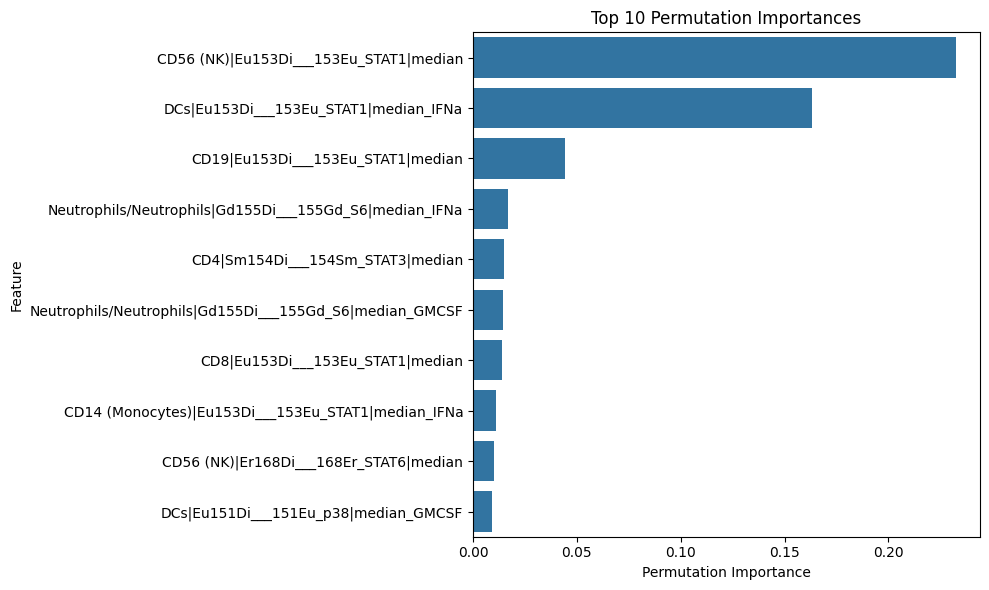

In [47]:
feature_importance = pd.read_csv('data/output/GMCSF & IFNa & unstim_RF_perm_ftimportance.csv')
feature_importance.head()

# Sort features by importance
feature_importance = feature_importance.sort_values(by="Permutation Importance", ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x="Permutation Importance", y="Feature", data=feature_importance.head(10))

# Formatting
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Permutation Importances")
plt.tight_layout()

plt.savefig("feature_importance.png")

# Show the plot
plt.show()

,Plate,ID,GA,Stims,EGA,TL,Timepoint,Source Population,Source FCS File,Unique Population Name
0,Plate1,1,26,GMCSF,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_GMCSF.fcs,LiveLeukocytes
1,Plate1,1,26,IFNa,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_IFNa.fcs,LiveLeukocytes
2,Plate1,1,26,IL246,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_IL246.fcs,LiveLeukocytes
3,Plate1,1,26,LPS,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_LPS.fcs,LiveLeukocytes
4,Plate1,1,26,unstim,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_unstim.fcs,LiveLeukocytes


RandomForestRegressor(n_estimators=110, random_state=42)

Accuracy: 91.12


<Figure size 600x600 with 0 Axes>

Text(0.5, 0, 'Actual Values (y_test)')

Text(0, 0.5, 'Predicted Values (y_pred)')

Text(0.5, 1.0, 'Actual vs Predicted Values')

(22.0, 40.0)

(22.0, 40.0)

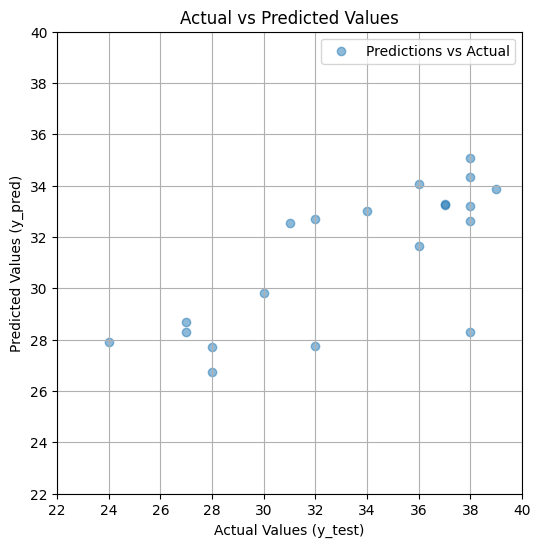

In [41]:
meta = pd.read_csv("data/input/FlowRepository_FR-FCM-Z3FH_samplelog.csv")
meta.head()

immu = pd.read_csv("data/input/Immunome_Labor_Onset_BG-Immunome_Labor_Onset_BG%202-Export%20Statistics-241025_1628.csv")

#%%
immu[['Plate', 'ID', 'GA', 'Stims']] = immu['file'].str.split('_', n=3, expand=True)
immu=immu[['Plate', 'ID', 'GA', 'Stims'] + [col for col in immu.columns if col not in ['Plate', 'ID', 'GA', 'Stims']]]
immu['Stims']=immu['Stims'].str.split('_').str[0]
immu=immu[immu.Plate!="Plate14"]
immu = immu.drop(columns=["CD19|Eu151Di___151Eu_p38|median", "CD56 (NK)|Dy161Di___161Dy_cPARP|median", "CD8|Dy161Di___161Dy_cPARP|median"])
immu[['ID','GA']]=immu[['ID','GA']].apply(pd.to_numeric)

#%%
meta.columns = ['Plate', 'ID', 'GA', 'Stims', 'EGA', 'TL', 'Timepoint', 'Source Population', 'Source FCS File', 'Unique Population Name']

#%%
bigdf=immu.merge(meta[['Plate','ID','GA','Stims','EGA','TL','Timepoint']])
bigdf = bigdf[~bigdf['file'].str.contains(r'-1\.fcs$', regex=True)]
# %%
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
stimulation=longdf.Stims.unique().tolist()

#%%
sti1='unstim'

input1=longdf[longdf.Stims==sti1]

input = input1

perm_imp_df=pd.read_csv('unstim_perm_importance.csv')
selectft=perm_imp_df[perm_imp_df['Permutation Importance']>10**(-3)].Feature.tolist()
input=input[["ID", "GA"] + selectft]

#%%
random.seed(18399)
patient=input.ID.unique().tolist()
random.shuffle(patient)
split_index = int(len(patient) * 0.85)
train_patients = patient[:split_index]
test_patients = patient[split_index:]

train_df=input[input.ID.isin(train_patients)]
test_df=input[input.ID.isin(test_patients)]

X_train=train_df.drop(['ID','GA'],axis=1)
X_test=test_df.drop(['ID','GA'],axis=1)
y_train=train_df['GA']
y_test=test_df['GA']

#%%
rf = RandomForestRegressor(n_estimators=110, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2=metrics.r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
print('Accuracy:', round(100*(1 - mape), 2))
# %%
import matplotlib.pyplot as plt
# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions vs Actual")


# Labels and title
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs Predicted Values")
plt.xlim(22, 40)
plt.ylim(22, 40)
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [35]:
print(immu.columns)

Index(['Plate', 'ID', 'GA', 'Stims', 'file',
       'Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median',
       'CD14 (Monocytes)|Sm149Di___149Sm_CREB|median',
       'CD19|Sm149Di___149Sm_CREB|median',
       'CD56 (NK)|Sm149Di___149Sm_CREB|median',
       'CD4|Sm149Di___149Sm_CREB|median', 'CD8|Sm149Di___149Sm_CREB|median',
       'DCs|Sm149Di___149Sm_CREB|median',
       'Neutrophils/Neutrophils|Nd150Di___150Nd_STAT5|median',
       'CD14 (Monocytes)|Nd150Di___150Nd_STAT5|median',
       'CD19|Nd150Di___150Nd_STAT5|median',
       'CD56 (NK)|Nd150Di___150Nd_STAT5|median',
       'CD4|Nd150Di___150Nd_STAT5|median', 'CD8|Nd150Di___150Nd_STAT5|median',
       'DCs|Nd150Di___150Nd_STAT5|median',
       'Neutrophils/Neutrophils|Eu151Di___151Eu_p38|median',
       'CD14 (Monocytes)|Eu151Di___151Eu_p38|median',
       'CD56 (NK)|Eu151Di___151Eu_p38|median',
       'CD4|Eu151Di___151Eu_p38|median', 'CD8|Eu151Di___151Eu_p38|median',
       'DCs|Eu151Di___151Eu_p38|median',
       'Neutroph

In [37]:
meta = pd.read_csv("data/input/FlowRepository_FR-FCM-Z3FH_samplelog.csv")
meta.head()

immu = pd.read_csv("data/input/Immunome_Labor_Onset_BG-Immunome_Labor_Onset_BG%202-Export%20Statistics-241025_1628.csv")

#%%
immu[['Plate', 'ID', 'GA', 'Stims']] = immu['file'].str.split('_', n=3, expand=True)
immu=immu[['Plate', 'ID', 'GA', 'Stims'] + [col for col in immu.columns if col not in ['Plate', 'ID', 'GA', 'Stims']]]
immu['Stims']=immu['Stims'].str.split('_').str[0]
immu=immu[immu.Plate!="Plate14"]
immu = immu.drop(columns=["CD19|Eu151Di___151Eu_p38|median", "CD56 (NK)|Dy161Di___161Dy_cPARP|median", "CD8|Dy161Di___161Dy_cPARP|median"])
immu[['ID','GA']]=immu[['ID','GA']].apply(pd.to_numeric)

#%%
meta.columns = ['Plate', 'ID', 'GA', 'Stims', 'EGA', 'TL', 'Timepoint', 'Source Population', 'Source FCS File', 'Unique Population Name']

#%%
bigdf=immu.merge(meta[['Plate','ID','GA','Stims','EGA','TL','Timepoint']])
bigdf = bigdf[~bigdf['file'].str.contains(r'-1\.fcs$', regex=True)]
# %%
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
stimulation=longdf.Stims.unique().tolist()

#%%
for sti in stimulation:
    input=longdf[longdf.Stims==sti]
    input = input.loc[:, input.nunique() > 1]
   
    random.seed(18399)
    patient=input.ID.unique().tolist()
    random.shuffle(patient)
    split_index = int(len(patient) * 0.85)
    train_patients = patient[:split_index]
    test_patients = patient[split_index:]

    train_df=input[input.ID.isin(train_patients)]
    test_df=input[input.ID.isin(test_patients)]

    X_train=train_df.drop(['ID','GA'],axis=1)
    X_test=test_df.drop(['ID','GA'],axis=1)
    y_train=train_df['GA']
    y_test=test_df['GA']

    rf = RandomForestRegressor(n_estimators=110, random_state=42, max_depth=30)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    print(sti)
    print(f"rmse: {rmse:.4f}")

    result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
    perm_imp_df = pd.DataFrame({'Feature': X_test.columns, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)

    input=longdf[longdf.Stims==sti]
    input = input.loc[:, input.nunique() > 1]
    selectft=perm_imp_df[perm_imp_df['Permutation Importance']>10**(-2)].Feature.tolist()
    input=input[["ID", "GA"] + selectft]

    random.seed(18399)
    patient=input.ID.unique().tolist()
    random.shuffle(patient)
    split_index = int(len(patient) * 0.85)
    train_patients = patient[:split_index]
    test_patients = patient[split_index:]

    train_df=input[input.ID.isin(train_patients)]
    test_df=input[input.ID.isin(test_patients)]

    X_train=train_df.drop(['ID','GA'],axis=1)
    X_test=test_df.drop(['ID','GA'],axis=1)
    y_train=train_df['GA']
    y_test=test_df['GA']

    rf = RandomForestRegressor(n_estimators=110, random_state=42, max_depth=30)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    print(f"After fts select rmse: {rmse:.4f}")
    perm_imp_df.to_csv(f'{sti}_perm_importance.csv')

,Plate,ID,GA,Stims,EGA,TL,Timepoint,Source Population,Source FCS File,Unique Population Name
0,Plate1,1,26,GMCSF,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_GMCSF.fcs,LiveLeukocytes
1,Plate1,1,26,IFNa,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_IFNa.fcs,LiveLeukocytes
2,Plate1,1,26,IL246,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_IL246.fcs,LiveLeukocytes
3,Plate1,1,26,LPS,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_LPS.fcs,LiveLeukocytes
4,Plate1,1,26,unstim,26.4,-101,G1,LiveLeukocytes,Plate1_001_26_unstim.fcs,LiveLeukocytes


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

GMCSF
rmse: 3.6001


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

After fts select rmse: 3.0504


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

IFNa
rmse: 3.9837


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

After fts select rmse: 3.8904


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

IL246
rmse: 3.0556


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

After fts select rmse: 2.7593


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

LPS
rmse: 4.8059


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

After fts select rmse: 3.6958


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

unstim
rmse: 4.2602


RandomForestRegressor(max_depth=30, n_estimators=110, random_state=42)

After fts select rmse: 3.7390


,Unnamed: 0,Feature,Permutation Importance
0,19,CD4|Sm154Di___154Sm_STAT3|median,0.396300
1,21,DCs|Sm154Di___154Sm_STAT3|median,0.021364
2,22,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median,0.021155
3,29,Neutrophils/Neutrophils|Gd156Di___156Gd_IkB|me...,0.011313
4,0,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|m...,0.011090


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Permutation Importance', ylabel='Feature'>

Text(0.5, 0, 'Permuation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 10 Permutation Importances')

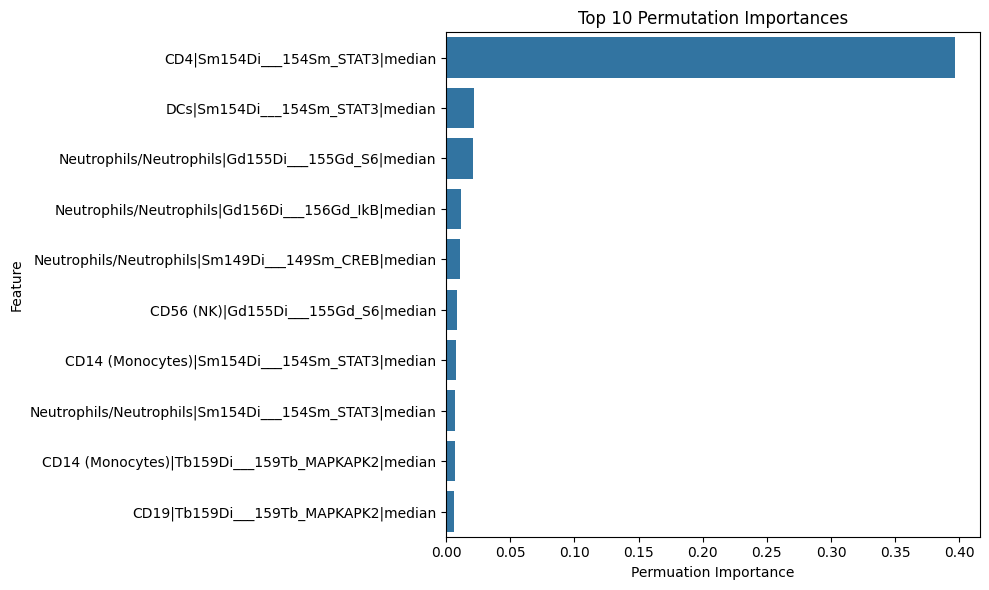

In [46]:
feature_importance = pd.read_csv('unstim_perm_importance.csv')
feature_importance.head()

# Sort features by importance
feature_importance = feature_importance.sort_values(by="Permutation Importance", ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x="Permutation Importance", y="Feature", data=feature_importance.head(10))

# Formatting
plt.xlabel("Permuation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Permutation Importances")
plt.tight_layout()

plt.savefig("feature_importance.png")

# Show the plot
plt.show()

,Unnamed: 0,Feature,Permutation Importance
0,23,CD4|Sm154Di___154Sm_STAT3|median,0.302427
1,11,CD4|Nd150Di___150Nd_STAT5|median,0.063168
2,20,Neutrophils/Neutrophils|Sm154Di___154Sm_STAT3|...,0.040481
3,26,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median,0.037547
4,59,Neutrophils/Neutrophils|Er167Di___167Er_ERK|me...,0.035589


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Permutation Importance', ylabel='Feature'>

Text(0.5, 0, 'Permuation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 10 Permutation Importances')

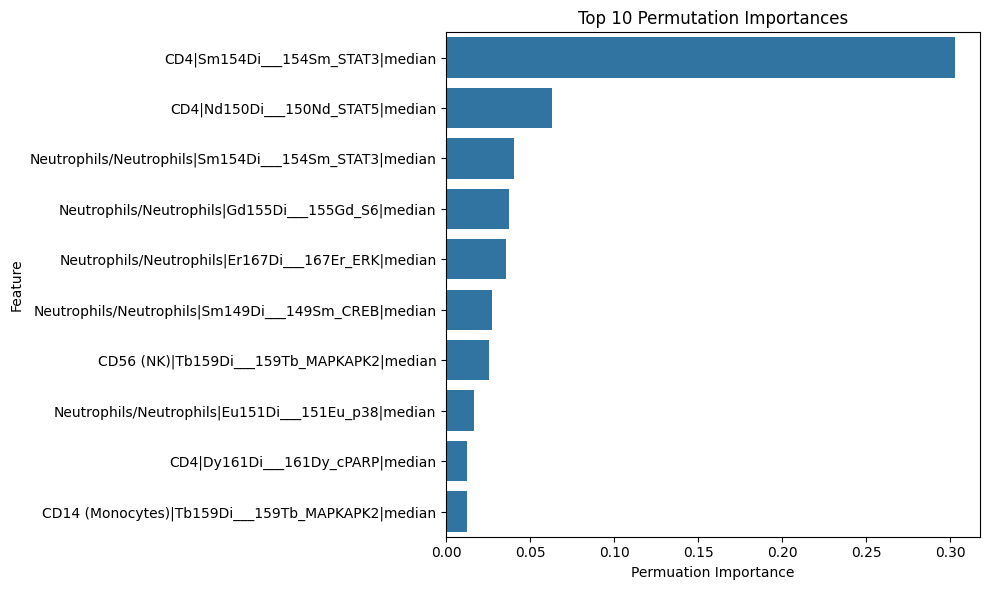

In [48]:
feature_importance = pd.read_csv('GMCSF_perm_importance.csv')
feature_importance.head()

# Sort features by importance
feature_importance = feature_importance.sort_values(by="Permutation Importance", ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x="Permutation Importance", y="Feature", data=feature_importance.head(10))

# Formatting
plt.xlabel("Permuation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Permutation Importances")
plt.tight_layout()

plt.savefig("feature_importance.png")

# Show the plot
plt.show()

,Unnamed: 0,Feature,Permutation Importance
0,23,CD56 (NK)|Eu153Di___153Eu_STAT1|median,0.163976
1,75,CD56 (NK)|Er168Di___168Er_STAT6|median,0.045035
2,73,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,0.016616
3,27,Neutrophils/Neutrophils|Sm154Di___154Sm_STAT3|...,0.014506
4,34,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median,0.011931


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Permutation Importance', ylabel='Feature'>

Text(0.5, 0, 'Permuation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 10 Permutation Importances')

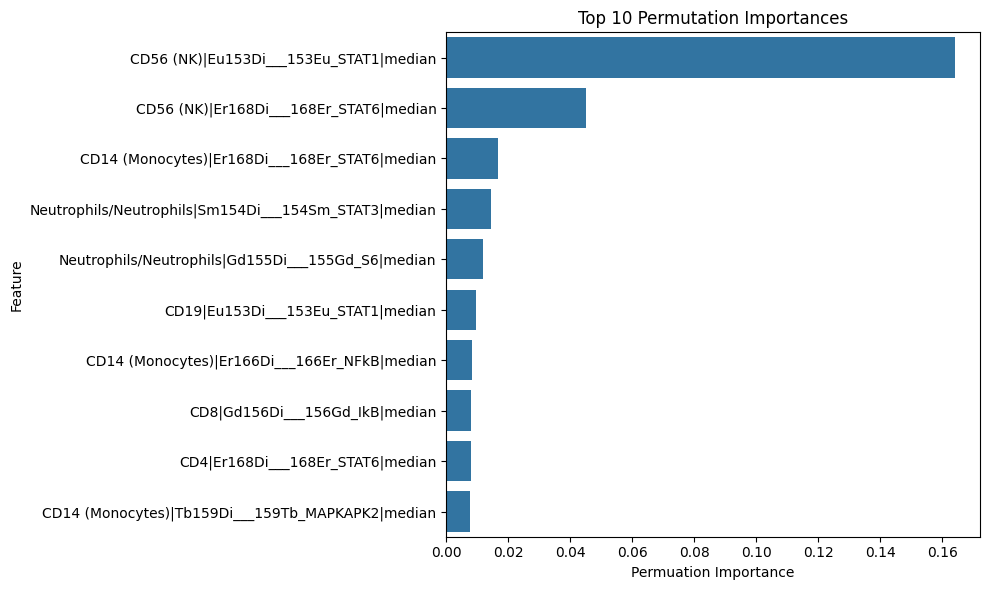

In [50]:
feature_importance = pd.read_csv('IFNa_perm_importance.csv')
feature_importance.head()

# Sort features by importance
feature_importance = feature_importance.sort_values(by="Permutation Importance", ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x="Permutation Importance", y="Feature", data=feature_importance.head(10))

# Formatting
plt.xlabel("Permuation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Permutation Importances")
plt.tight_layout()

plt.savefig("feature_importance.png")

# Show the plot
plt.show()

In [ ]:
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Add UMAP results back to DataFrame
longdf["UMAP1"] = embedding[:, 0]
longdf["UMAP2"] = embedding[:, 1]

# Plot UMAP
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue=longdf["GA"],  # Color by stimulus
    #style=longdf["GA"],  # Different markers for gestational age
    palette="viridis",  # Adjust as needed
    data=longdf,
    alpha=0.8
)

ax.legend(title="Gestational Age")  # Set title for the hue legend

# Add plot title
plt.title("UMAP of Top 34 Immune Profiles by Gestational Age")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("feature_importance.png")

plt.show()

RandomForestRegressor(n_estimators=110, random_state=42)

Accuracy: 92.73


<Figure size 600x600 with 0 Axes>

Text(0.5, 0, 'Actual Values (y_test)')

Text(0, 0.5, 'Predicted Values (y_pred)')

Text(0.5, 1.0, 'Actual vs Predicted Values')

(22.0, 40.0)

(22.0, 40.0)

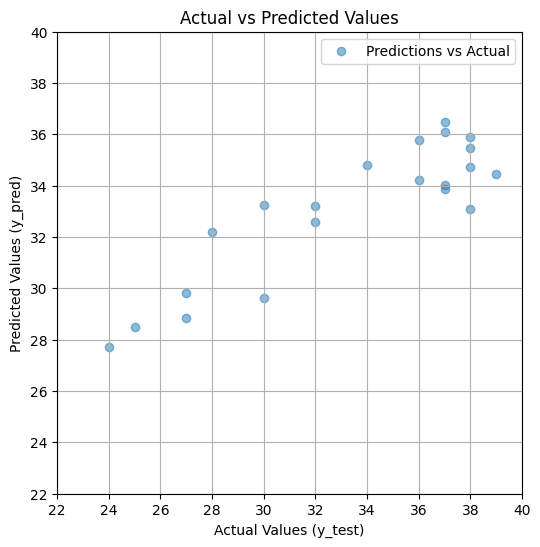

In [51]:
#%%
import pandas as pd
import numpy as np
import os
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from itertools import combinations
from functools import reduce
from sklearn import metrics

# %%
meta=pd.read_csv("data/input/FlowRepository_FR-FCM-Z3FH_samplelog.csv")
immu=pd.read_csv("data/input/Immunome_Labor_Onset_BG-Immunome_Labor_Onset_BG%202-Export%20Statistics-241025_1628.csv")

#%%
immu[['Plate', 'ID', 'GA', 'Stims']] = immu['file'].str.split('_', n=3, expand=True)
immu=immu[['Plate', 'ID', 'GA', 'Stims'] + [col for col in immu.columns if col not in ['Plate', 'ID', 'GA', 'Stims']]]
immu['Stims']=immu['Stims'].str.split('_').str[0]
immu=immu[immu.Plate!="Plate14"]
immu = immu.drop(columns=["CD19|Eu151Di___151Eu_p38|median", "CD56 (NK)|Dy161Di___161Dy_cPARP|median", "CD8|Dy161Di___161Dy_cPARP|median"])
immu[['ID','GA']]=immu[['ID','GA']].apply(pd.to_numeric)

#%%
meta.columns = ['Plate', 'ID', 'GA', 'Stims', 'EGA', 'TL', 'Timepoint', 'Source Population', 'Source FCS File', 'Unique Population Name']

#%%
bigdf=immu.merge(meta[['Plate','ID','GA','Stims','EGA','TL','Timepoint']])
bigdf = bigdf[~bigdf['file'].str.contains(r'-1\.fcs$', regex=True)]
# %%
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
stimulation=longdf.Stims.unique().tolist()

#%%
sti1='GMCSF'
sti2='IFNa'
sti3='unstim'

input1=longdf[longdf.Stims==sti1]
input1 = input1.loc[:, input1.nunique() > 1]
input2=longdf[longdf.Stims==sti2]
input2 = input2.loc[:, input2.nunique() > 1]
input3=longdf[longdf.Stims==sti3]
input3 = input3.loc[:, input3.nunique() > 1]

input = input1.merge(input2, on=["ID", "GA"], suffixes=('_' + str(sti1), '_' + str(sti2))).merge(input3, on=["ID", "GA"])

perm_imp_df=pd.read_csv('data/output/GMCSF & IFNa & unstim_RF_perm_ftimportance.csv')
selectft=perm_imp_df[perm_imp_df['Permutation Importance']>10**(-3)].Feature.tolist()
input=input[["ID", "GA"] + selectft]

#%%
random.seed(18399)
patient=input.ID.unique().tolist()
random.shuffle(patient)
split_index = int(len(patient) * 0.85)
train_patients = patient[:split_index]
test_patients = patient[split_index:]

train_df=input[input.ID.isin(train_patients)]
test_df=input[input.ID.isin(test_patients)]

X_train=train_df.drop(['ID','GA'],axis=1)
X_test=test_df.drop(['ID','GA'],axis=1)
y_train=train_df['GA']
y_test=test_df['GA']

#%%
rf = RandomForestRegressor(n_estimators=110, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2=metrics.r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
print('Accuracy:', round(100*(1 - mape), 2))
# %%
import matplotlib.pyplot as plt
# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions vs Actual")


# Labels and title
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs Predicted Values")
plt.xlim(22, 40)
plt.ylim(22, 40)
plt.legend()
plt.grid(True)

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': X_test.columns, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
perm_imp_df.to_csv("best_perm_importance.csv")

# Show plot
plt.show()

,Unnamed: 0,Feature,Permutation Importance
0,0,CD56 (NK)|Eu153Di___153Eu_STAT1|median,0.200450
1,1,DCs|Eu153Di___153Eu_STAT1|median_IFNa,0.165736
2,2,CD19|Eu153Di___153Eu_STAT1|median,0.048975
3,7,CD14 (Monocytes)|Eu153Di___153Eu_STAT1|median_...,0.025084
4,5,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|med...,0.022781


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Permutation Importance', ylabel='Feature'>

Text(0.5, 0, 'Permuation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 10 Permutation Importances')

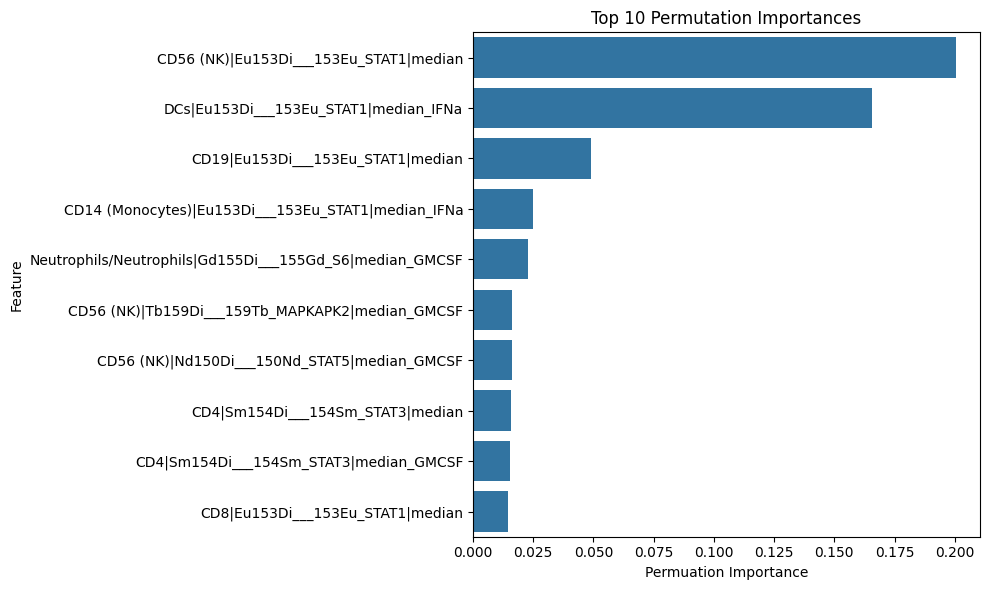

In [52]:
feature_importance = pd.read_csv('best_perm_importance.csv')
feature_importance.head()

# Sort features by importance
feature_importance = feature_importance.sort_values(by="Permutation Importance", ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x="Permutation Importance", y="Feature", data=feature_importance.head(10))

# Formatting
plt.xlabel("Permuation Importance")
plt.ylabel("Feature")
plt.title("Top 10 Permutation Importances")
plt.tight_layout()

plt.savefig("feature_importance.png")

# Show the plot
plt.show()

,GA,Stims
0,26,GMCSF
1,26,IFNa
4,26,unstim
5,33,GMCSF
6,33,IFNa


,ID,GA,Stims,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
0,1,26,GMCSF,3.310,2.41,0.0,0.0996,0.0,0.0,1.380,...,1.020,0.846,0.000977,0.490,0.0504,0.00,0.0000,2.66,2.09,0.0455
1,1,26,IFNa,0.874,1.44,0.0,0.0000,0.0,0.0,1.020,...,0.935,0.746,0.000000,0.000,7.3700,5.81,0.0274,6.34,4.42,10.5000
4,1,26,unstim,0.977,1.26,0.0,0.0000,0.0,0.0,0.848,...,0.963,0.848,0.000000,0.000,0.0000,0.00,0.0000,2.48,1.93,0.0000
5,1,33,GMCSF,3.350,2.37,0.0,0.0851,0.0,0.0,1.560,...,0.958,0.712,0.000000,0.643,0.0000,0.00,0.0000,2.55,1.93,0.0000
6,1,33,IFNa,0.866,1.69,0.0,0.0000,0.0,0.0,1.130,...,0.925,0.738,0.000000,0.608,12.7000,5.72,0.0232,6.14,4.43,13.7000


,Neutrophils/Neutrophils|Nd150Di___150Nd_STAT5|median,CD14 (Monocytes)|Nd150Di___150Nd_STAT5|median,CD4|Nd150Di___150Nd_STAT5|median,CD4|Eu151Di___151Eu_p38|median,CD8|Eu151Di___151Eu_p38|median,CD19|Eu153Di___153Eu_STAT1|median,CD56 (NK)|Eu153Di___153Eu_STAT1|median,CD4|Eu153Di___153Eu_STAT1|median,CD8|Eu153Di___153Eu_STAT1|median,CD4|Sm154Di___154Sm_STAT3|median,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median,Neutrophils/Neutrophils|Gd156Di___156Gd_IkB|median,CD56 (NK)|Gd156Di___156Gd_IkB|median,CD14 (Monocytes)|Tb159Di___159Tb_MAPKAPK2|median,DCs|Tb159Di___159Tb_MAPKAPK2|median,Neutrophils/Neutrophils|Er166Di___166Er_NFkB|median,CD56 (NK)|Er168Di___168Er_STAT6|median
0,35.400,17.300,2.28,0.0,0.000,0.00,0.00,0.0,0.00,1.080,14.20,0.869,0.2420,2.240,0.995,1.620,0.0000
1,7.120,15.600,16.10,0.0,0.124,5.81,3.69,12.4,9.30,35.200,9.37,1.470,0.2000,0.466,0.469,0.920,0.0274
4,0.886,0.515,2.34,0.0,0.000,0.00,0.00,0.0,0.00,1.090,9.25,1.540,0.1630,0.434,0.607,0.945,0.0000
5,34.800,16.900,2.65,0.0,0.000,0.00,0.00,0.0,0.00,0.256,14.10,0.633,0.0157,2.980,0.786,1.170,0.0000
6,14.900,17.100,16.60,0.0,0.108,3.40,3.38,9.5,7.21,31.500,7.27,0.981,0.2170,0.543,0.581,0.879,0.0232


/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'UMAP of Immune Profiles by Gestational Age')

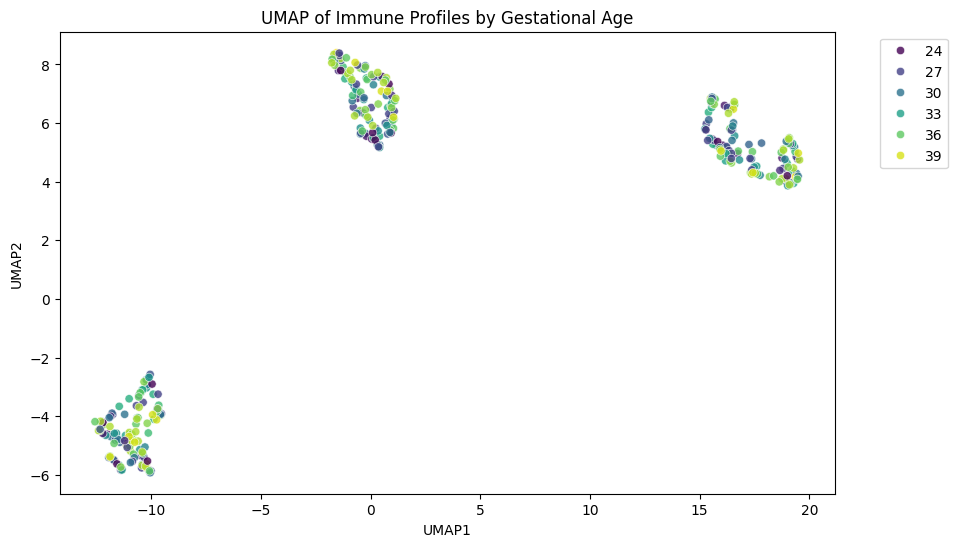

In [57]:
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
longdf = longdf[longdf['Stims'].isin(['unstim', 'IFNa', 'GMCSF'])]

meta_cols = longdf[["GA", "Stims"]]  # Adjust these to your actual metadata column names
meta_cols.head()

features = longdf.drop(columns=meta_cols)
features = features.drop(columns='ID')

df1 = pd.read_csv('best_perm_importance.csv')
selected_columns = df1['Feature'].tolist()

# Keep only columns in df2 that exist in df1['Feature']
features = features.loc[:, features.columns.isin(selected_columns)]

longdf.head()

features.head()

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Add UMAP results back to DataFrame
longdf["UMAP1"] = embedding[:, 0]
longdf["UMAP2"] = embedding[:, 1]

# Plot UMAP
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue=longdf["GA"],  # Color by stimulus
    #style=longdf["GA"],  # Different markers for gestational age
    palette="viridis",  # Adjust as needed
    data=longdf,
    alpha=0.8
)

ax.legend(title="Gestational Age")  # Set title for the hue legend

# Add plot title
plt.title("UMAP of Immune Profiles by Gestational Age")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("feature_importance.png")

plt.show()

,GA,Stims
4,26,unstim
9,33,unstim
14,35,unstim
19,25,unstim
24,30,unstim


,ID,GA,Stims,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
4,1,26,unstim,0.977,1.26,0.0,0.000,0.0,0.0000,0.848,...,0.963,0.848,0.0,0.0,0.0,0.0,0.0,2.48,1.93,0.0
9,1,33,unstim,0.773,1.01,0.0,0.000,0.0,0.0000,0.737,...,0.931,0.749,0.0,0.0,0.0,0.0,0.0,2.55,1.96,0.0
14,1,35,unstim,1.660,1.48,0.0,0.171,0.0,0.0000,1.160,...,1.080,0.772,0.0,0.0,0.0,0.0,0.0,2.78,1.98,0.0
19,3,25,unstim,1.430,1.71,0.0,0.655,0.0,0.0481,1.530,...,1.520,1.270,0.0,0.0,0.0,0.0,0.0,3.41,2.86,0.0
24,3,30,unstim,1.970,1.87,0.0,0.378,0.0,0.0000,1.480,...,1.560,1.250,0.0,0.0,0.0,0.0,0.0,3.46,2.99,0.0


,Neutrophils/Neutrophils|Nd150Di___150Nd_STAT5|median,CD14 (Monocytes)|Nd150Di___150Nd_STAT5|median,CD4|Nd150Di___150Nd_STAT5|median,CD4|Eu151Di___151Eu_p38|median,CD8|Eu151Di___151Eu_p38|median,CD19|Eu153Di___153Eu_STAT1|median,CD56 (NK)|Eu153Di___153Eu_STAT1|median,CD4|Eu153Di___153Eu_STAT1|median,CD8|Eu153Di___153Eu_STAT1|median,CD4|Sm154Di___154Sm_STAT3|median,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median,Neutrophils/Neutrophils|Gd156Di___156Gd_IkB|median,CD56 (NK)|Gd156Di___156Gd_IkB|median,CD14 (Monocytes)|Tb159Di___159Tb_MAPKAPK2|median,DCs|Tb159Di___159Tb_MAPKAPK2|median,Neutrophils/Neutrophils|Er166Di___166Er_NFkB|median,CD56 (NK)|Er168Di___168Er_STAT6|median
4,0.886,0.515,2.34,0.0,0.0,0.0,0.0,0.0,0.0,1.090,9.25,1.54,0.163,0.434,0.607,0.945,0.0
9,0.670,0.464,2.46,0.0,0.0,0.0,0.0,0.0,0.0,0.261,7.16,1.06,0.155,0.407,0.529,0.710,0.0
14,0.821,0.514,2.84,0.0,0.0,0.0,0.0,0.0,0.0,0.339,9.35,1.63,0.296,0.463,0.603,0.895,0.0
19,1.090,0.719,1.64,0.0,0.0,0.0,0.0,0.0,0.0,0.275,8.28,2.24,0.355,0.569,0.545,1.730,0.0
24,1.010,0.725,2.38,0.0,0.0,0.0,0.0,0.0,0.0,0.445,7.63,1.73,0.502,0.720,0.854,1.780,0.0


/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'UMAP of Immune Profiles by Gestational Age')

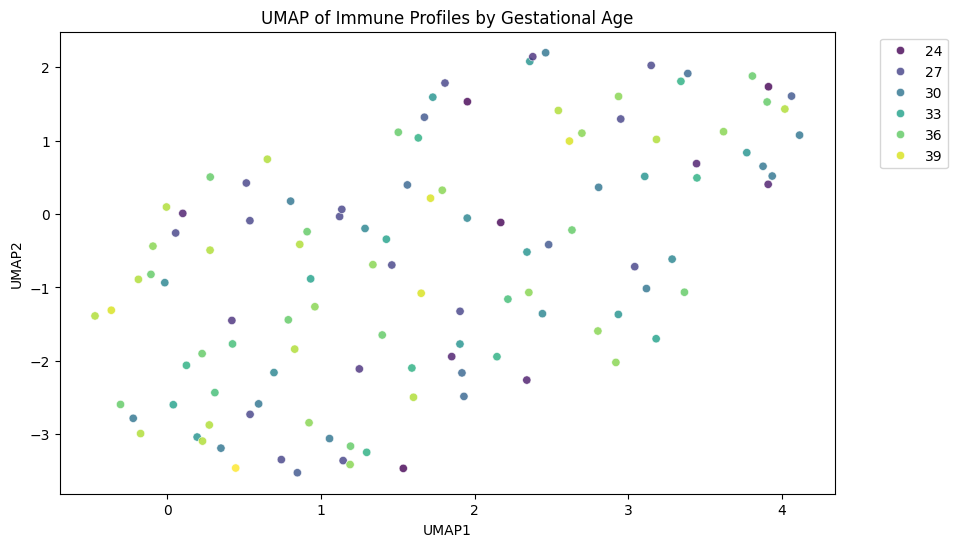

In [58]:
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
longdf = longdf[longdf['Stims'].isin(['unstim'])]

meta_cols = longdf[["GA", "Stims"]]  # Adjust these to your actual metadata column names
meta_cols.head()

features = longdf.drop(columns=meta_cols)
features = features.drop(columns='ID')

df1 = pd.read_csv('best_perm_importance.csv')
selected_columns = df1['Feature'].tolist()

# Keep only columns in df2 that exist in df1['Feature']
features = features.loc[:, features.columns.isin(selected_columns)]

longdf.head()

features.head()

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Add UMAP results back to DataFrame
longdf["UMAP1"] = embedding[:, 0]
longdf["UMAP2"] = embedding[:, 1]

# Plot UMAP
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue=longdf["GA"],  # Color by stimulus
    #style=longdf["GA"],  # Different markers for gestational age
    palette="viridis",  # Adjust as needed
    data=longdf,
    alpha=0.8
)

ax.legend(title="Gestational Age")  # Set title for the hue legend

# Add plot title
plt.title("UMAP of Immune Profiles by Gestational Age")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("feature_importance.png")

plt.show()

,GA,Stims
1,26,IFNa
6,33,IFNa
11,35,IFNa
16,25,IFNa
21,30,IFNa


,ID,GA,Stims,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
1,1,26,IFNa,0.874,1.44,0.0,0.000,0.0,0.0000,1.02,...,0.935,0.746,0.0,0.000,7.37,5.81,0.0274,6.34,4.42,10.5
6,1,33,IFNa,0.866,1.69,0.0,0.000,0.0,0.0000,1.13,...,0.925,0.738,0.0,0.608,12.70,5.72,0.0232,6.14,4.43,13.7
11,1,35,IFNa,1.540,2.29,0.0,0.185,0.0,0.0000,1.15,...,0.969,0.736,0.0,0.742,15.80,7.55,0.2060,7.25,5.13,16.7
16,3,25,IFNa,1.400,2.10,0.0,0.433,0.0,0.0215,1.90,...,1.520,1.270,0.0,1.020,22.00,8.77,0.3970,8.65,6.68,25.2
21,3,30,IFNa,2.010,2.51,0.0,0.377,0.0,0.0000,2.00,...,1.580,1.270,0.0,1.300,19.80,7.99,0.4500,8.29,6.66,25.7


,Neutrophils/Neutrophils|Nd150Di___150Nd_STAT5|median,CD14 (Monocytes)|Nd150Di___150Nd_STAT5|median,CD4|Nd150Di___150Nd_STAT5|median,CD4|Eu151Di___151Eu_p38|median,CD8|Eu151Di___151Eu_p38|median,CD19|Eu153Di___153Eu_STAT1|median,CD56 (NK)|Eu153Di___153Eu_STAT1|median,CD4|Eu153Di___153Eu_STAT1|median,CD8|Eu153Di___153Eu_STAT1|median,CD4|Sm154Di___154Sm_STAT3|median,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median,Neutrophils/Neutrophils|Gd156Di___156Gd_IkB|median,CD56 (NK)|Gd156Di___156Gd_IkB|median,CD14 (Monocytes)|Tb159Di___159Tb_MAPKAPK2|median,DCs|Tb159Di___159Tb_MAPKAPK2|median,Neutrophils/Neutrophils|Er166Di___166Er_NFkB|median,CD56 (NK)|Er168Di___168Er_STAT6|median
1,7.12,15.6,16.1,0.0000,0.1240,5.81,3.69,12.40,9.30,35.2,9.37,1.470,0.200,0.466,0.469,0.920,0.0274
6,14.90,17.1,16.6,0.0000,0.1080,3.40,3.38,9.50,7.21,31.5,7.27,0.981,0.217,0.543,0.581,0.879,0.0232
11,14.70,19.5,19.1,0.0901,0.2480,3.86,3.92,11.90,8.66,35.6,7.59,1.100,0.252,0.756,0.649,0.945,0.2060
16,14.00,19.5,17.8,0.0000,0.0285,2.89,3.27,9.72,7.42,34.6,8.63,2.150,0.377,0.624,0.622,1.930,0.3970
21,13.60,19.0,17.7,0.0000,0.0824,3.16,4.12,10.30,7.80,35.5,7.90,1.630,0.546,0.813,0.851,2.030,0.4500


/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'UMAP of Immune Profiles by Gestational Age')

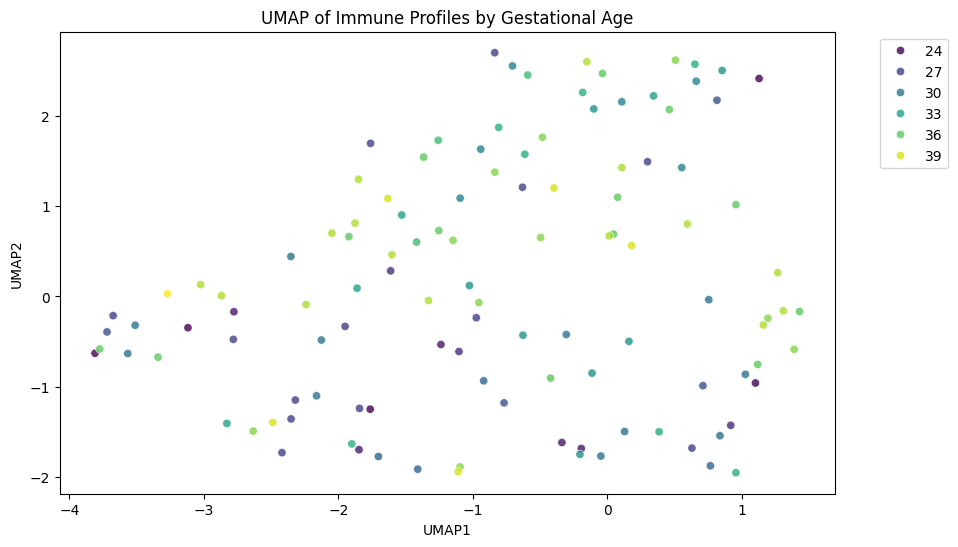

In [59]:
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
longdf = longdf[longdf['Stims'].isin(['IFNa'])]

meta_cols = longdf[["GA", "Stims"]]  # Adjust these to your actual metadata column names
meta_cols.head()

features = longdf.drop(columns=meta_cols)
features = features.drop(columns='ID')

df1 = pd.read_csv('best_perm_importance.csv')
selected_columns = df1['Feature'].tolist()

# Keep only columns in df2 that exist in df1['Feature']
features = features.loc[:, features.columns.isin(selected_columns)]

longdf.head()

features.head()

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Add UMAP results back to DataFrame
longdf["UMAP1"] = embedding[:, 0]
longdf["UMAP2"] = embedding[:, 1]

# Plot UMAP
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue=longdf["GA"],  # Color by stimulus
    #style=longdf["GA"],  # Different markers for gestational age
    palette="viridis",  # Adjust as needed
    data=longdf,
    alpha=0.8
)

ax.legend(title="Gestational Age")  # Set title for the hue legend

# Add plot title
plt.title("UMAP of Immune Profiles by Gestational Age")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("feature_importance.png")

plt.show()

,GA,Stims
0,26,GMCSF
5,33,GMCSF
10,35,GMCSF
15,25,GMCSF
20,30,GMCSF


,ID,GA,Stims,Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median,CD14 (Monocytes)|Sm149Di___149Sm_CREB|median,CD19|Sm149Di___149Sm_CREB|median,CD56 (NK)|Sm149Di___149Sm_CREB|median,CD4|Sm149Di___149Sm_CREB|median,CD8|Sm149Di___149Sm_CREB|median,DCs|Sm149Di___149Sm_CREB|median,...,CD4|Er167Di___167Er_ERK|median,CD8|Er167Di___167Er_ERK|median,DCs|Er167Di___167Er_ERK|median,Neutrophils/Neutrophils|Er168Di___168Er_STAT6|median,CD14 (Monocytes)|Er168Di___168Er_STAT6|median,CD19|Er168Di___168Er_STAT6|median,CD56 (NK)|Er168Di___168Er_STAT6|median,CD4|Er168Di___168Er_STAT6|median,CD8|Er168Di___168Er_STAT6|median,DCs|Er168Di___168Er_STAT6|median
0,1,26,GMCSF,3.31,2.41,0.0,0.0996,0.0,0.000,1.38,...,1.020,0.846,0.000977,0.490,0.0504,0.0,0.0,2.66,2.09,0.0455
5,1,33,GMCSF,3.35,2.37,0.0,0.0851,0.0,0.000,1.56,...,0.958,0.712,0.000000,0.643,0.0000,0.0,0.0,2.55,1.93,0.0000
10,1,35,GMCSF,4.05,3.06,0.0,0.1830,0.0,0.000,1.75,...,1.120,0.831,0.000000,0.831,0.0412,0.0,0.0,2.89,2.03,0.0229
15,3,25,GMCSF,5.29,3.49,0.0,0.7050,0.0,0.137,2.59,...,1.650,1.360,0.000000,0.918,0.0924,0.0,0.0,3.56,2.96,0.1760
20,3,30,GMCSF,4.55,3.88,0.0,0.4200,0.0,0.000,2.58,...,1.670,1.380,0.000000,0.971,0.0848,0.0,0.0,3.67,3.06,0.0248


,Neutrophils/Neutrophils|Nd150Di___150Nd_STAT5|median,CD14 (Monocytes)|Nd150Di___150Nd_STAT5|median,CD4|Nd150Di___150Nd_STAT5|median,CD4|Eu151Di___151Eu_p38|median,CD8|Eu151Di___151Eu_p38|median,CD19|Eu153Di___153Eu_STAT1|median,CD56 (NK)|Eu153Di___153Eu_STAT1|median,CD4|Eu153Di___153Eu_STAT1|median,CD8|Eu153Di___153Eu_STAT1|median,CD4|Sm154Di___154Sm_STAT3|median,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median,Neutrophils/Neutrophils|Gd156Di___156Gd_IkB|median,CD56 (NK)|Gd156Di___156Gd_IkB|median,CD14 (Monocytes)|Tb159Di___159Tb_MAPKAPK2|median,DCs|Tb159Di___159Tb_MAPKAPK2|median,Neutrophils/Neutrophils|Er166Di___166Er_NFkB|median,CD56 (NK)|Er168Di___168Er_STAT6|median
0,35.4,17.3,2.28,0.0,0.0,0.0,0.0,0.0,0.0,1.080,14.2,0.869,0.2420,2.24,0.995,1.62,0.0
5,34.8,16.9,2.65,0.0,0.0,0.0,0.0,0.0,0.0,0.256,14.1,0.633,0.0157,2.98,0.786,1.17,0.0
10,36.8,19.1,2.84,0.0,0.0,0.0,0.0,0.0,0.0,0.306,15.3,0.971,0.3120,1.69,0.687,1.64,0.0
15,34.9,19.2,1.92,0.0,0.0,0.0,0.0,0.0,0.0,0.320,17.6,1.550,0.4560,2.81,1.370,2.69,0.0
20,32.6,18.1,2.40,0.0,0.0,0.0,0.0,0.0,0.0,0.496,18.1,1.460,0.5080,3.83,1.270,2.54,0.0


/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'UMAP of Immune Profiles by Gestational Age')

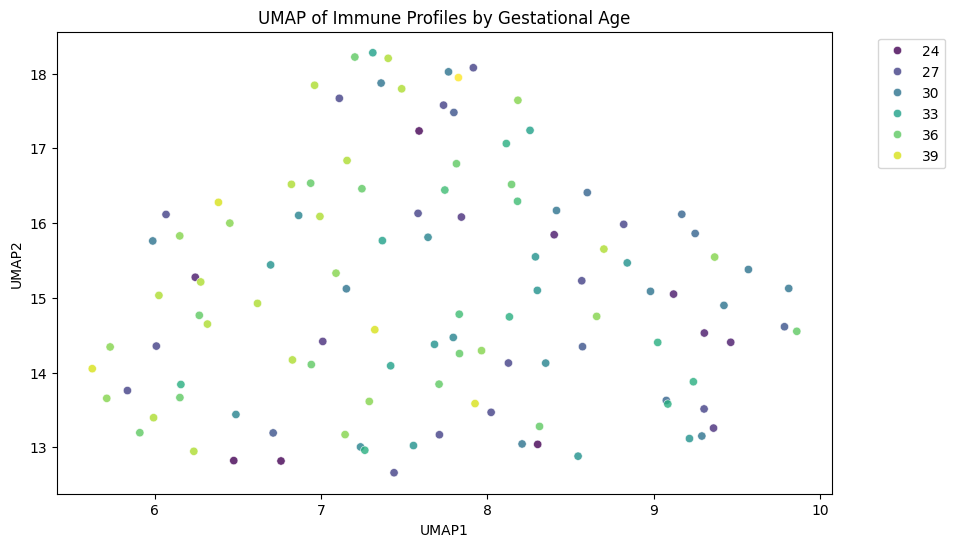

In [60]:
longdf=bigdf.drop(columns=['Plate','file','TL','EGA','Timepoint'])
longdf = longdf[longdf['Stims'].isin(['GMCSF'])]

meta_cols = longdf[["GA", "Stims"]]  # Adjust these to your actual metadata column names
meta_cols.head()

features = longdf.drop(columns=meta_cols)
features = features.drop(columns='ID')

df1 = pd.read_csv('best_perm_importance.csv')
selected_columns = df1['Feature'].tolist()

# Keep only columns in df2 that exist in df1['Feature']
features = features.loc[:, features.columns.isin(selected_columns)]

longdf.head()

features.head()

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Add UMAP results back to DataFrame
longdf["UMAP1"] = embedding[:, 0]
longdf["UMAP2"] = embedding[:, 1]

# Plot UMAP
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue=longdf["GA"],  # Color by stimulus
    #style=longdf["GA"],  # Different markers for gestational age
    palette="viridis",  # Adjust as needed
    data=longdf,
    alpha=0.8
)

ax.legend(title="Gestational Age")  # Set title for the hue legend

# Add plot title
plt.title("UMAP of Immune Profiles by Gestational Age")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("feature_importance.png")

plt.show()

<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Permutation Importance', ylabel='Feature'>

Text(0.5, 0, 'Permutation Importance')

Text(0, 0.5, 'Feature')

Text(0.5, 1.0, 'Top 20 Features Across Conditions')

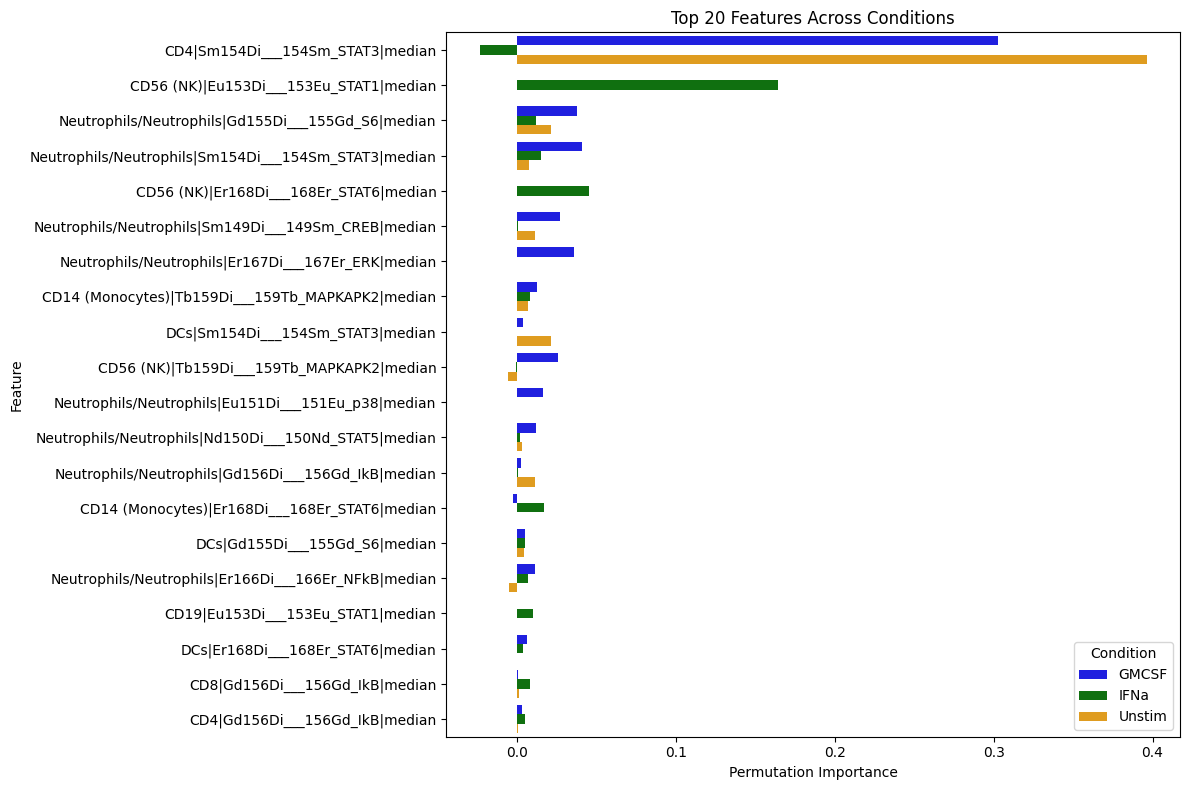

In [62]:
# Load data and label conditions
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Combine all data
df = pd.concat([gmcsf, ifna, unstim])

# Identify shared features
feature_counts = df["Feature"].value_counts()
shared_features = feature_counts[feature_counts > 1].index

# Add a column to indicate whether a feature is shared
df["Shared"] = df["Feature"].isin(shared_features)

# Sort by overall importance (sum of all conditions)
df["Total Importance"] = df.groupby("Feature")["Permutation Importance"].transform("sum")
df = df.sort_values(by="Total Importance", ascending=False).drop(columns=["Total Importance"])

condition_palette = {
    'GMCSF': 'blue',
    'IFNa': 'green',
    'Unstim': 'orange'
}

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df[df["Feature"].isin(df["Feature"].unique()[:20])],  # Top 20 overall features
    x="Permutation Importance",
    y="Feature",
    hue="Condition",
    palette=condition_palette,
    dodge=True
)

# Formatting
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 20 Features Across Conditions")
plt.legend(title="Condition")
plt.tight_layout()
plt.savefig("feature_importance_comparison.png")
plt.show()


/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


ValueError: The palette dictionary is missing keys: {'CD14 (Monocytes)|Tb159Di___159Tb_MAPKAPK2|median', 'CD56 (NK)|Tb159Di___159Tb_MAPKAPK2|median', 'Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median', 'CD4|Nd150Di___150Nd_STAT5|median', 'CD4|Dy161Di___161Dy_cPARP|median', 'Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median', 'CD4|Sm154Di___154Sm_STAT3|median', 'Neutrophils/Neutrophils|Eu151Di___151Eu_p38|median', 'Neutrophils/Neutrophils|Er167Di___167Er_ERK|median', 'Neutrophils/Neutrophils|Sm154Di___154Sm_STAT3|median'}

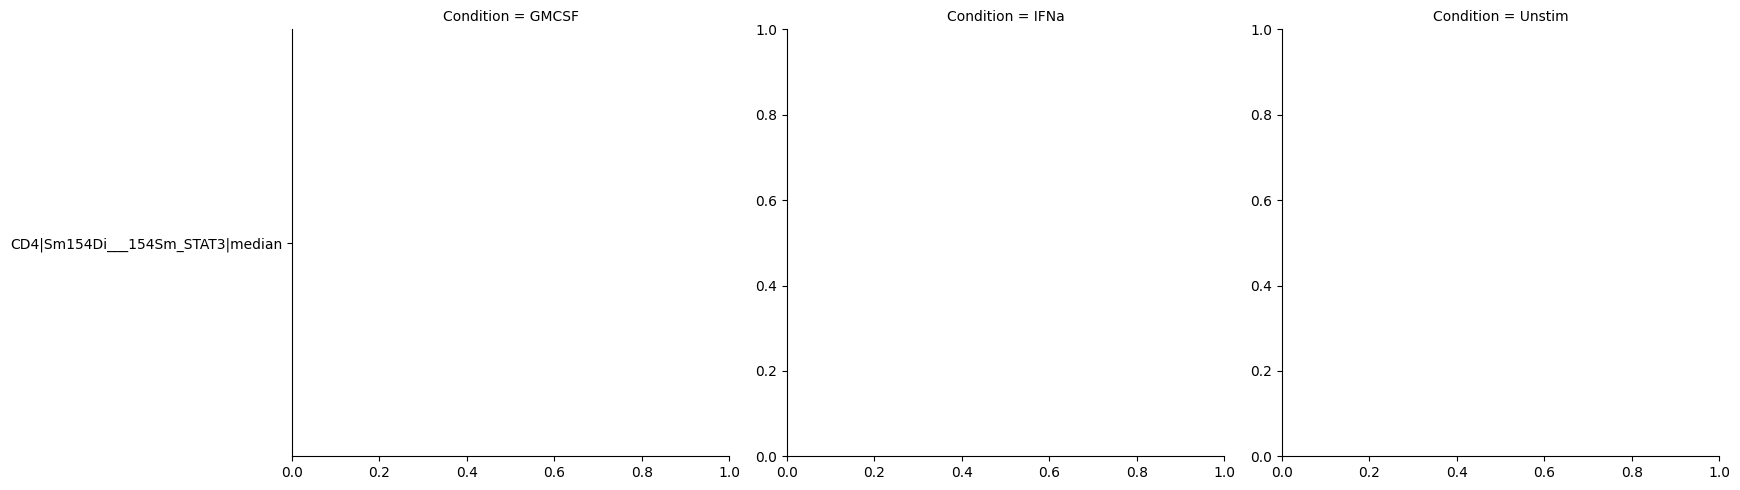

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and label conditions
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Combine all data
df = pd.concat([gmcsf, ifna, unstim])

# Select top 10 features for each condition
top_gmcsf = gmcsf.nlargest(10, 'Permutation Importance')
top_ifna = ifna.nlargest(10, 'Permutation Importance')
top_unstim = unstim.nlargest(10, 'Permutation Importance')

# Combine into one dataframe
top_features_df = pd.concat([top_gmcsf, top_ifna, top_unstim])

condition_palette = {
    'GMCSF': 'blue',
    'IFNa': 'green',
    'Unstim': 'orange'
}

# Plot using Seaborn's FacetGrid
g = sns.FacetGrid(top_features_df, col="Condition", height=5, col_wrap=3, sharey=False)
g.map(sns.barplot, "Permutation Importance", "Feature", palette=condition_palette)

# Formatting
g.set_axis_labels("Permutation Importance", "Feature")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Features by Condition", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.85)  # Adjust title position

plt.savefig("feature_importance_facet.png")
plt.show()


/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/wendysu0/ih-hackathon-pregnancy-clock/.conda/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


ValueError: The palette dictionary is missing keys: {'CD14 (Monocytes)|Tb159Di___159Tb_MAPKAPK2|median', 'CD56 (NK)|Tb159Di___159Tb_MAPKAPK2|median', 'Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median', 'CD4|Nd150Di___150Nd_STAT5|median', 'CD4|Dy161Di___161Dy_cPARP|median', 'Neutrophils/Neutrophils|Sm149Di___149Sm_CREB|median', 'CD4|Sm154Di___154Sm_STAT3|median', 'Neutrophils/Neutrophils|Eu151Di___151Eu_p38|median', 'Neutrophils/Neutrophils|Er167Di___167Er_ERK|median', 'Neutrophils/Neutrophils|Sm154Di___154Sm_STAT3|median'}

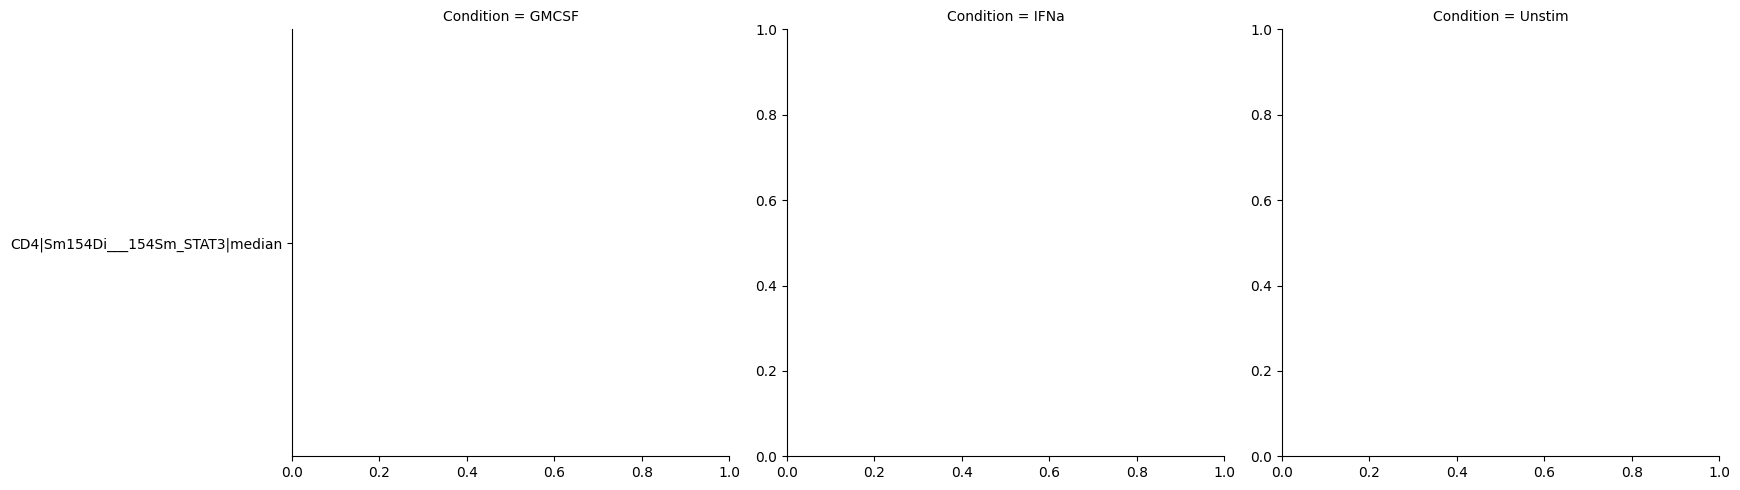

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and label conditions
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Combine all data
df = pd.concat([gmcsf, ifna, unstim])

# Select top 10 features for each condition
top_gmcsf = gmcsf.nlargest(10, 'Permutation Importance')
top_ifna = ifna.nlargest(10, 'Permutation Importance')
top_unstim = unstim.nlargest(10, 'Permutation Importance')

# Combine into one dataframe
top_features_df = pd.concat([top_gmcsf, top_ifna, top_unstim])

# Define the color palette for each condition
condition_palette = {
    'GMCSF': 'blue',
    'IFNa': 'green',
    'Unstim': 'orange'
}

# Plot using Seaborn's FacetGrid
g = sns.FacetGrid(top_features_df, col="Condition", height=5, col_wrap=3, sharey=False)
g.map(sns.barplot, "Permutation Importance", "Feature", hue="Condition", palette=condition_palette)

# Formatting
g.set_axis_labels("Permutation Importance", "Feature")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Features by Condition", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.85)  # Adjust title position

plt.savefig("feature_importance_facet.png")
plt.show()


In [67]:
top_features_df.head()

,Unnamed: 0,Feature,Permutation Importance,Condition
0,23,CD4|Sm154Di___154Sm_STAT3|median,0.302427,GMCSF
1,11,CD4|Nd150Di___150Nd_STAT5|median,0.063168,GMCSF
2,20,Neutrophils/Neutrophils|Sm154Di___154Sm_STAT3|...,0.040481,GMCSF
3,26,Neutrophils/Neutrophils|Gd155Di___155Gd_S6|median,0.037547,GMCSF
4,59,Neutrophils/Neutrophils|Er167Di___167Er_ERK|me...,0.035589,GMCSF


<Figure size 1000x1500 with 0 Axes>

Text(0.5, 0.98, 'Top 10 Features by Condition')

<Figure size 1000x1500 with 0 Axes>

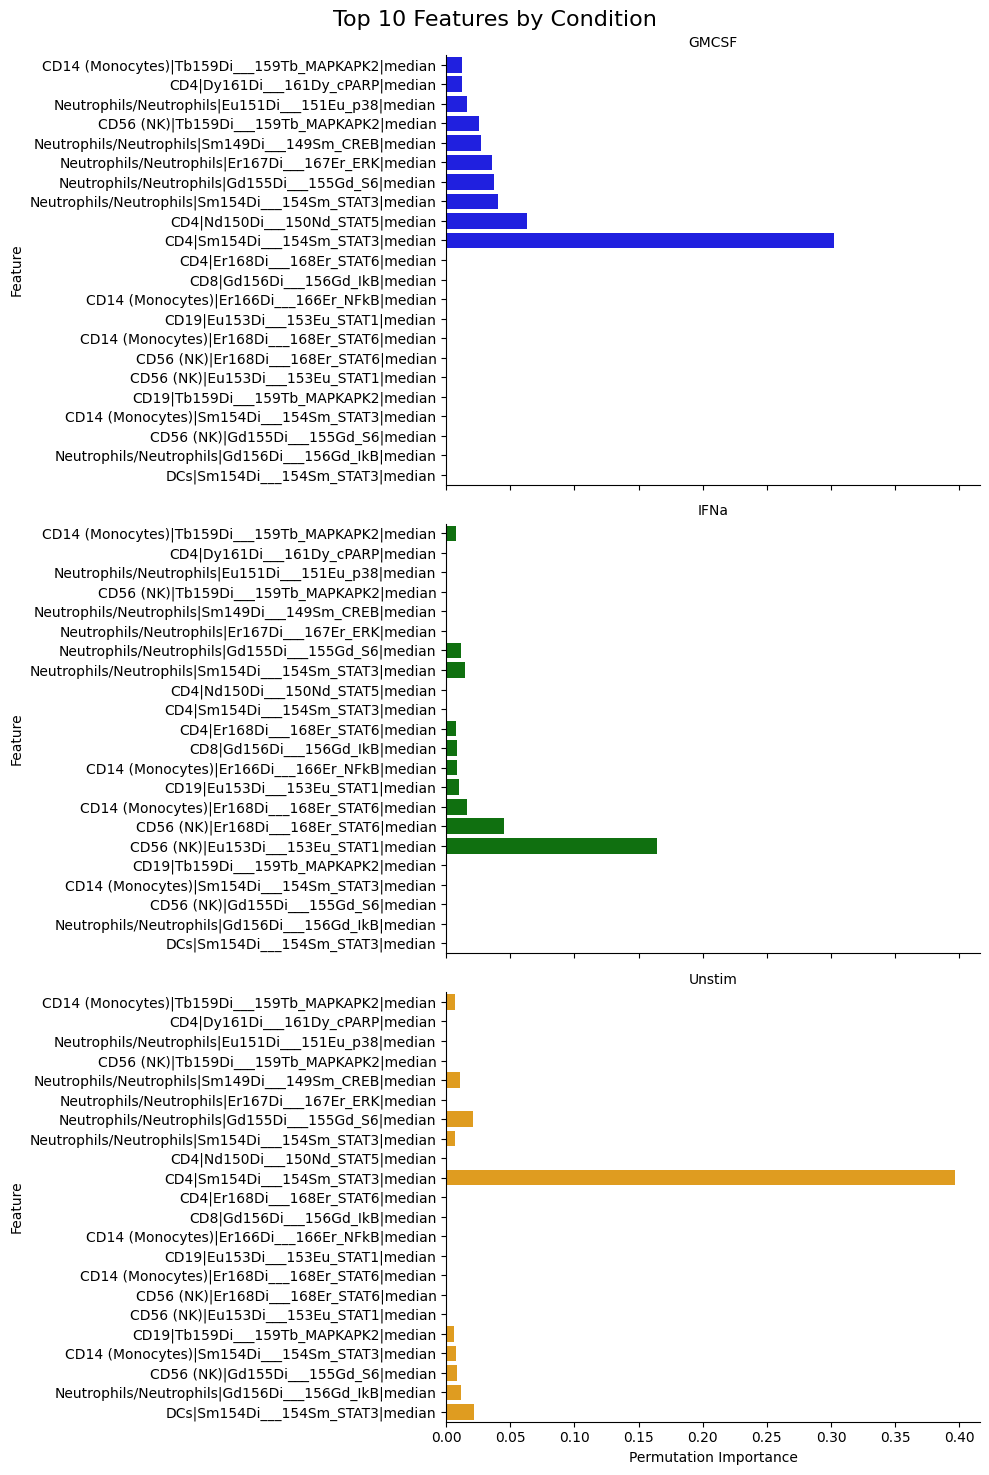

In [73]:
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Select top 10 features for each condition
top_gmcsf = gmcsf.nlargest(10, 'Permutation Importance')
top_ifna = ifna.nlargest(10, 'Permutation Importance')
top_unstim = unstim.nlargest(10, 'Permutation Importance')

# Combine into one dataframe
top_features_df = pd.concat([top_gmcsf, top_ifna, top_unstim])

# Create FacetGrid with vertical layout
plt.figure(figsize=(10, 15))
g = sns.FacetGrid(top_features_df, col="Condition", col_wrap=1, height=5, aspect=2)

# Custom plotting function to sort features by importance with condition-specific colors
def plot_sorted_bars(data, color, **kwargs):
    condition = data['Condition'].iloc[0]
    color_map = {'GMCSF': 'blue', 'IFNa': 'green', 'Unstim': 'orange'}
    sorted_data = data.sort_values('Permutation Importance', ascending=True)
    ax = plt.gca()
    sns.barplot(x='Permutation Importance', y='Feature', data=sorted_data, 
                ax=ax, color=color_map[condition], **kwargs)

# Map the custom plotting function
g.map_dataframe(plot_sorted_bars)

# Formatting
g.set_axis_labels("Permutation Importance", "Feature")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Features by Condition", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

plt.savefig("feature_importance_vertical_facet.png")
plt.show()

<Figure size 1000x1500 with 0 Axes>

/var/folders/v9/1rkjwpk576564njm_gt438km0000gp/T/ipykernel_20128/2550869268.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(sorted_data['Feature'])  # Ensure y-axis shows only features for this condition
/var/folders/v9/1rkjwpk576564njm_gt438km0000gp/T/ipykernel_20128/2550869268.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(sorted_data['Feature'])  # Ensure y-axis shows only features for this condition
/var/folders/v9/1rkjwpk576564njm_gt438km0000gp/T/ipykernel_20128/2550869268.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(sorted_data['Feature'])  # Ensure y-axis shows only features for this condition


Text(0.5, 0.98, 'Top 10 Features by Condition')

<Figure size 1000x1500 with 0 Axes>

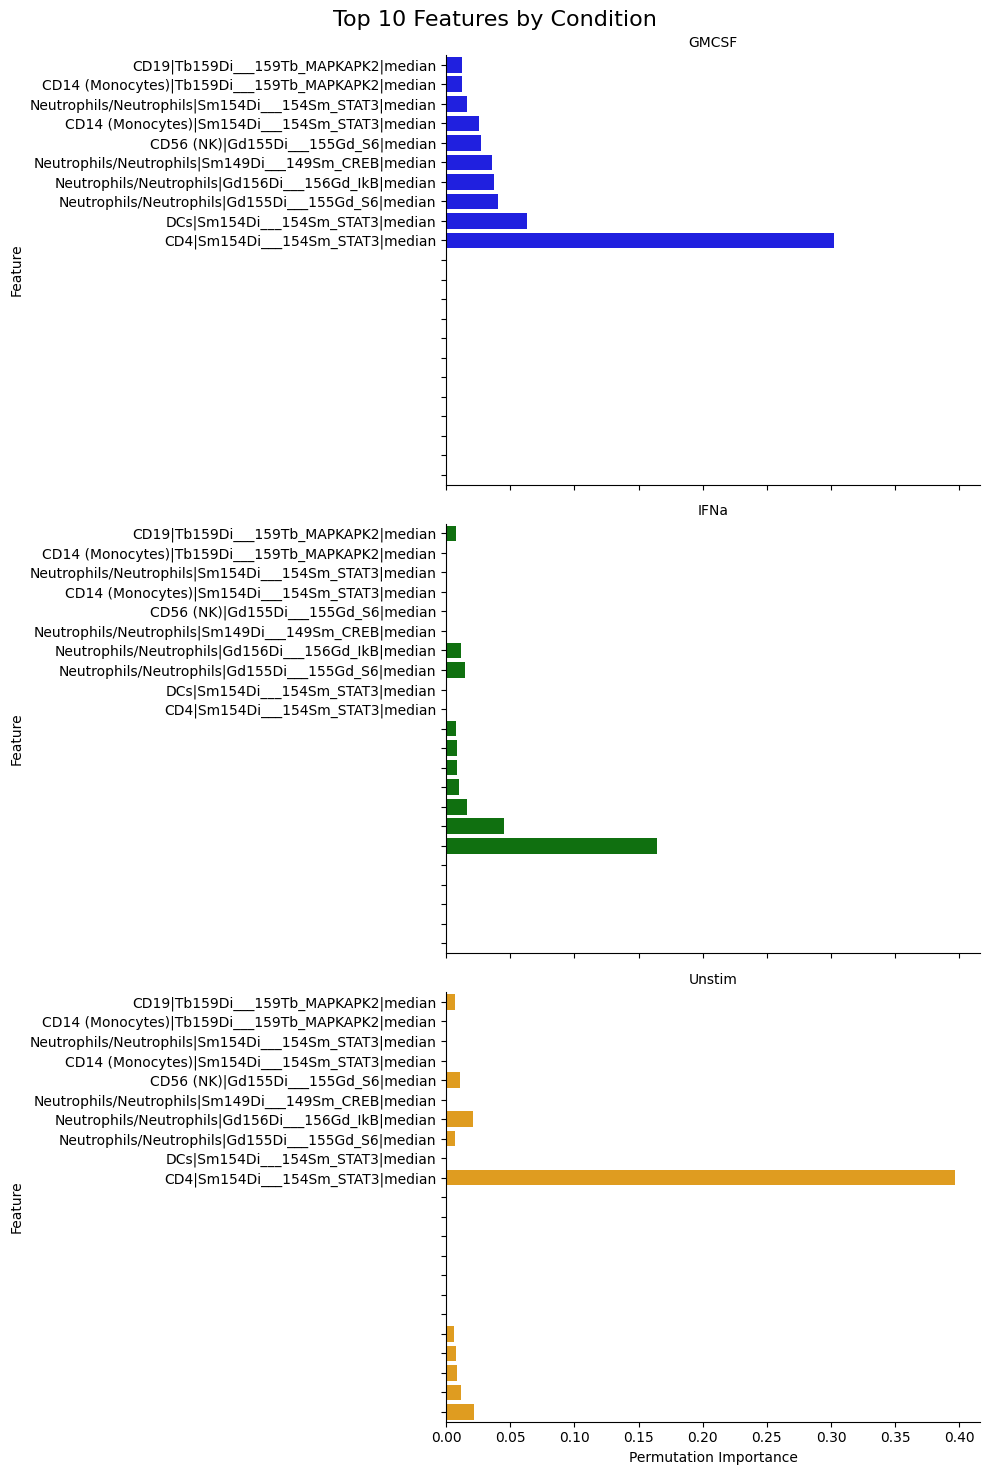

In [72]:
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Select top 10 features for each condition
top_gmcsf = gmcsf.nlargest(10, 'Permutation Importance')
top_ifna = ifna.nlargest(10, 'Permutation Importance')
top_unstim = unstim.nlargest(10, 'Permutation Importance')

# Combine into one dataframe
top_features_df = pd.concat([top_gmcsf, top_ifna, top_unstim])

# Create FacetGrid with vertical layout and independent y-axes
plt.figure(figsize=(10, 15))
g = sns.FacetGrid(top_features_df, col="Condition", col_wrap=1, height=5, aspect=2)

# Custom plotting function to sort features by importance with condition-specific colors
def plot_sorted_bars(data, color, **kwargs):
    condition = data['Condition'].iloc[0]
    color_map = {'GMCSF': 'blue', 'IFNa': 'green', 'Unstim': 'orange'}
    sorted_data = data.sort_values('Permutation Importance', ascending=True)
    ax = plt.gca()
    sns.barplot(x='Permutation Importance', y='Feature', data=sorted_data, 
                ax=ax, color=color_map[condition], **kwargs)
    ax.set_yticklabels(sorted_data['Feature'])  # Ensure y-axis shows only features for this condition

# Map the custom plotting function
g.map_dataframe(plot_sorted_bars)

# Formatting
g.set_axis_labels("Permutation Importance", "Feature")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Features by Condition", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

plt.savefig("feature_importance_vertical_facet.png")
plt.show()

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 0.98, 'Top 10 Features by Condition')

<Figure size 1500x1000 with 0 Axes>

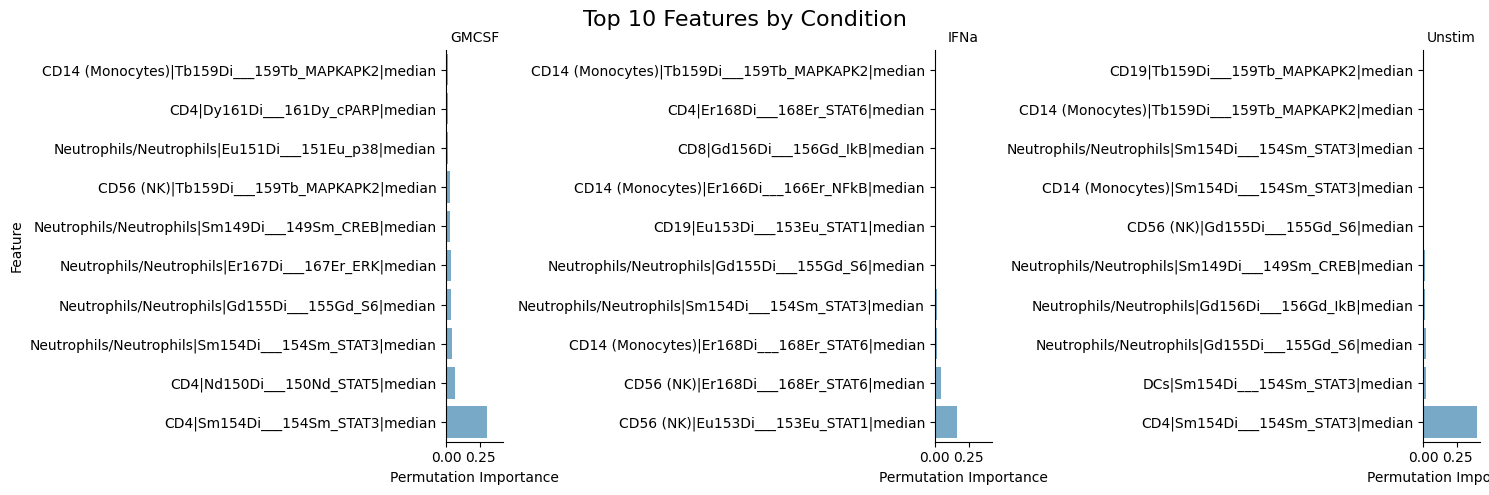

In [ ]:

# Load data and label conditions
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Combine all data
df = pd.concat([gmcsf, ifna, unstim])

# Select top 10 features for each condition, sorted within each condition
top_gmcsf = gmcsf.nlargest(10, 'Permutation Importance')
top_ifna = ifna.nlargest(10, 'Permutation Importance')
top_unstim = unstim.nlargest(10, 'Permutation Importance')

# Combine into one dataframe
top_features_df = pd.concat([top_gmcsf, top_ifna, top_unstim])

# Define the color palette for each condition
condition_palette = {
    'GMCSF': 'green',
    'IFNa': 'red',
    'Unstim': 'blue'
}

# Create FacetGrid
plt.figure(figsize=(15, 10))
g = sns.FacetGrid(top_features_df, col="Condition", height=5, col_wrap=3, sharey=False)

# Custom plotting function to sort features by importance
def plot_sorted_bars(data, color, **kwargs):
    sorted_data = data.sort_values('Permutation Importance', ascending=True)
    ax = plt.gca()
    sns.barplot(x='Permutation Importance', y='Feature', data=sorted_data, 
                ax=ax, color=color, **kwargs)

# Map the custom plotting function
g.map_dataframe(plot_sorted_bars, color=plt.cm.Blues(0.5))

# Formatting
g.set_axis_labels("Permutation Importance", "Feature")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Features by Condition", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.90)

plt.savefig("feature_importance_facet.png")
plt.show()

<Figure size 1000x1500 with 0 Axes>

Text(0.5, 0.98, 'Top 10 Features by Condition')

<Figure size 1000x1500 with 0 Axes>

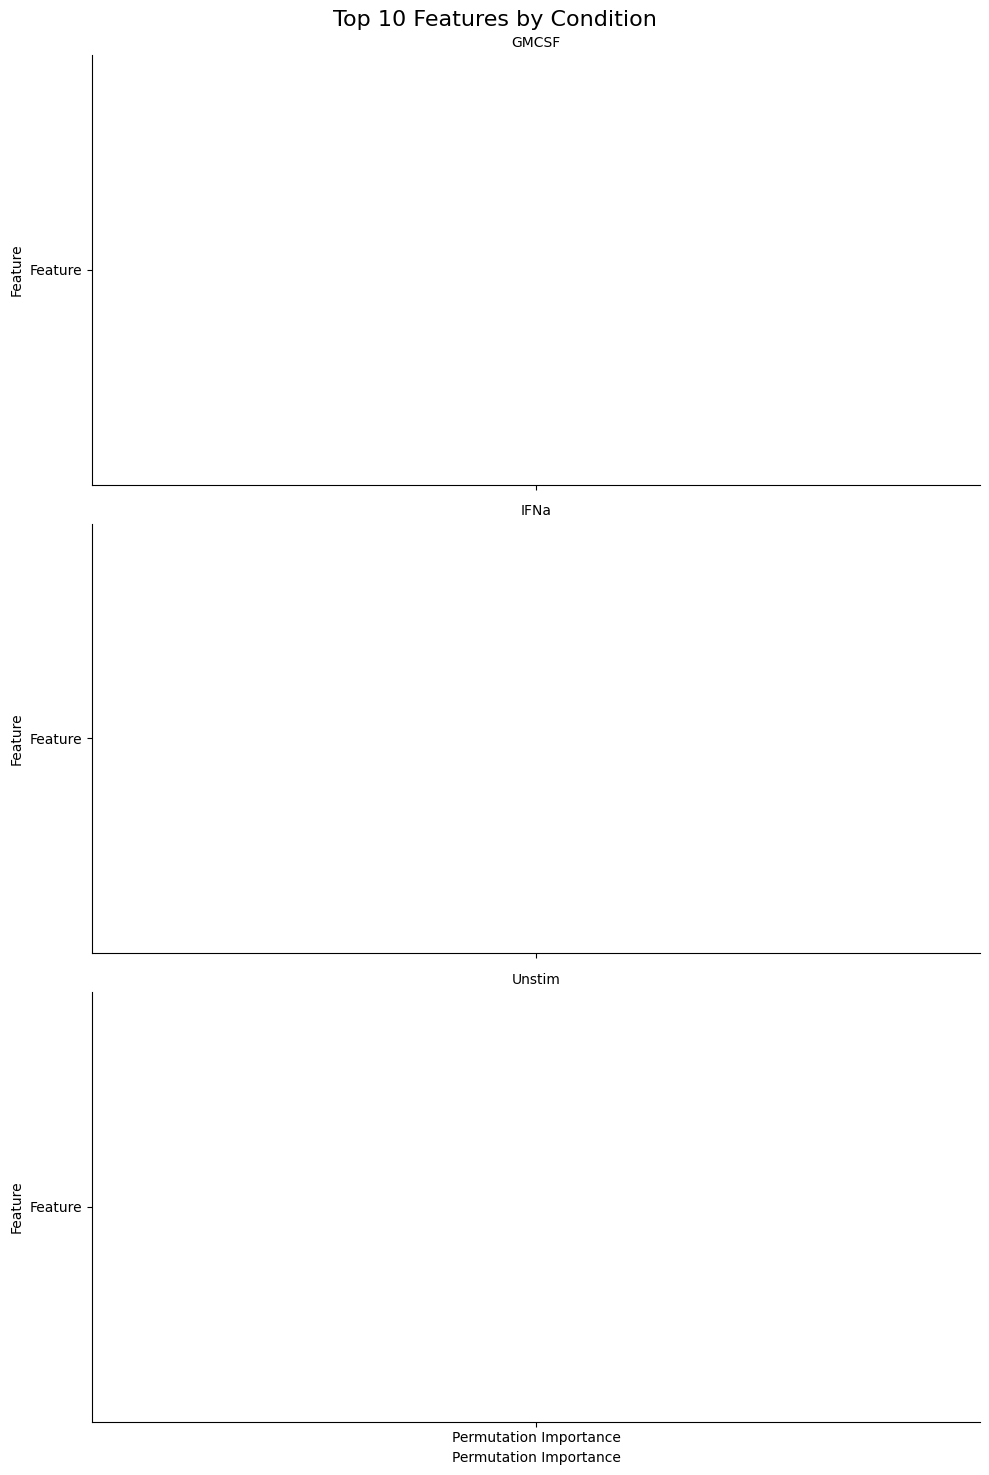

In [77]:
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Combine all data
df = pd.concat([gmcsf, ifna, unstim])

# Select top 10 features for each condition
top_gmcsf = gmcsf.nlargest(10, 'Permutation Importance')
top_ifna = ifna.nlargest(10, 'Permutation Importance')
top_unstim = unstim.nlargest(10, 'Permutation Importance')

# Combine into one dataframe
top_features_df = pd.concat([top_gmcsf, top_ifna, top_unstim])

# Create FacetGrid with vertical layout
plt.figure(figsize=(10, 15))
g = sns.FacetGrid(top_features_df, col="Condition", col_wrap=1, height=5, aspect=2)

# Custom plotting function to sort features by importance
def plot_sorted_bars(x, y, color, **kwargs):
    condition_colors = {'GMCSF': 'blue', 'IFNa': 'green', 'Unstim': 'orange'}
    condition = kwargs.get('data')['Condition'].iloc[0]
    plt.gca().barh(y, x, color=condition_colors[condition])

# Map the custom plotting function
g.map_dataframe(plot_sorted_bars, 'Permutation Importance', 'Feature')

# Formatting
g.set_axis_labels("Permutation Importance", "Feature")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Features by Condition", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

plt.savefig("feature_importance_vertical_facet.png")
plt.show()

<Figure size 2000x5000 with 0 Axes>

Text(0.5, 0.98, 'Top 10 Features by Condition')

<Figure size 2000x5000 with 0 Axes>

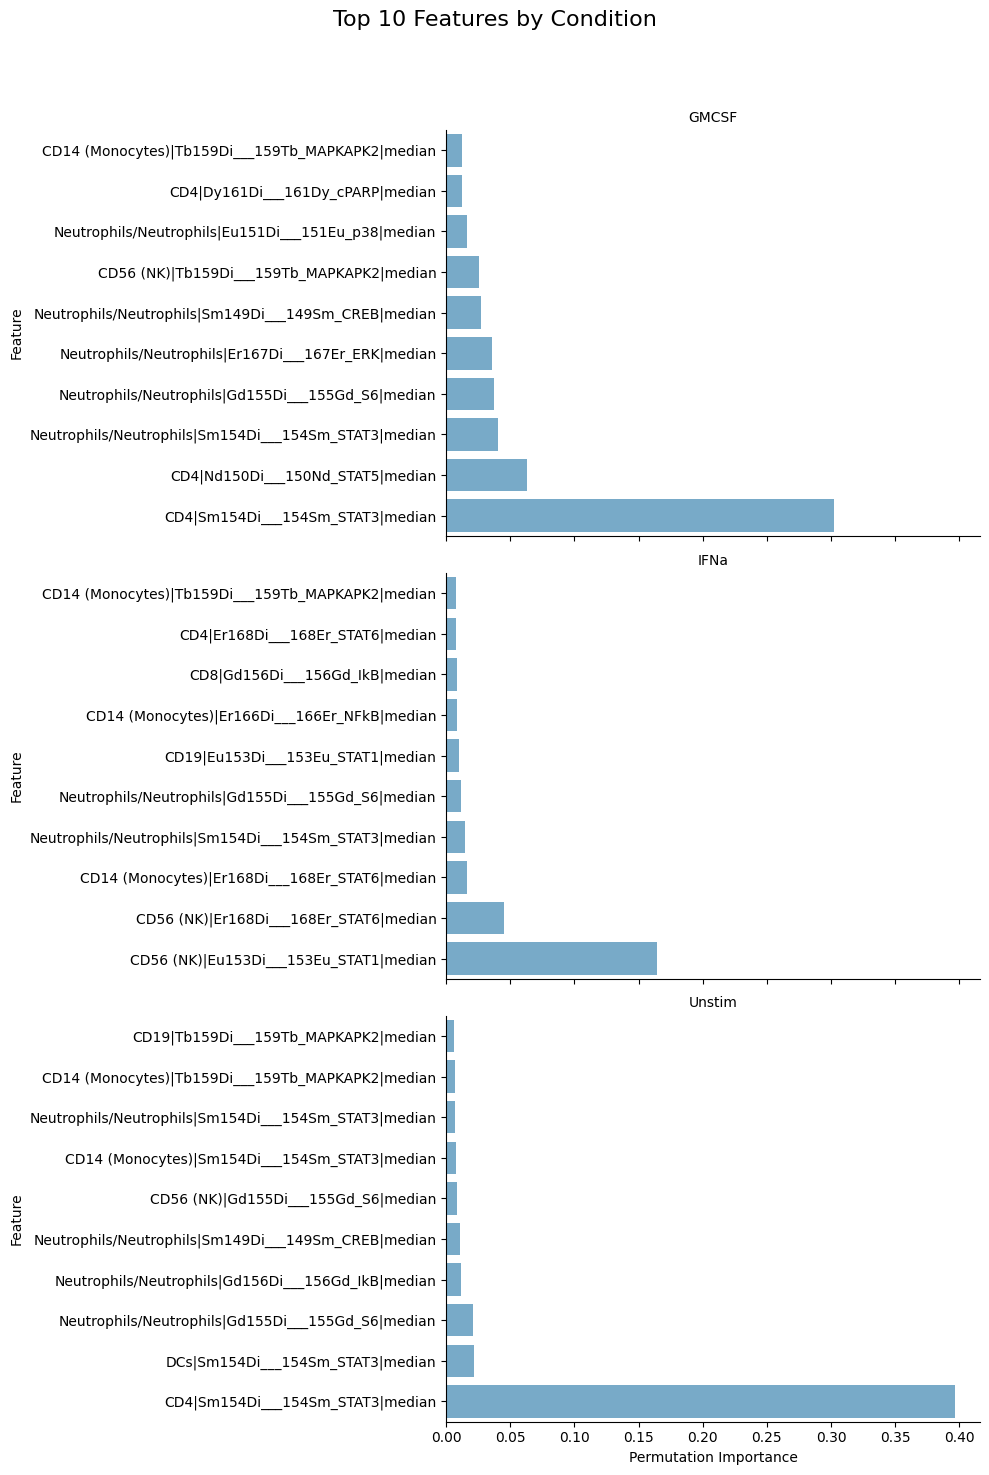

In [82]:

# Load data and label conditions
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Combine all data
df = pd.concat([gmcsf, ifna, unstim])

# Select top 10 features for each condition, sorted within each condition
top_gmcsf = gmcsf.nlargest(10, 'Permutation Importance')
top_ifna = ifna.nlargest(10, 'Permutation Importance')
top_unstim = unstim.nlargest(10, 'Permutation Importance')

# Combine into one dataframe
top_features_df = pd.concat([top_gmcsf, top_ifna, top_unstim])

# Define the color palette for each condition
condition_palette = {
    'GMCSF': 'green',
    'IFNa': 'red',
    'Unstim': 'blue'
}

# Create FacetGrid
# Increase figure width and adjust aspect ratio
plt.figure(figsize=(20, 50))  # Increased width from 15 to 20
g = sns.FacetGrid(top_features_df, col="Condition", height=5, col_wrap=1, sharey=False, aspect=2)  # Increased aspect ratio

# Add more space on sides
g.fig.subplots_adjust(left=0.2, right=0.95, top=0.90)

# Custom plotting function to sort features by importance
def plot_sorted_bars(data, color, **kwargs):
    sorted_data = data.sort_values('Permutation Importance', ascending=True)
    ax = plt.gca()
    sns.barplot(x='Permutation Importance', y='Feature', data=sorted_data, 
                ax=ax, color=color, **kwargs)

# Map the custom plotting function
g.map_dataframe(plot_sorted_bars, color=plt.cm.Blues(0.5))

# Formatting
g.set_axis_labels("Permutation Importance", "Feature")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Features by Condition", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.90)

plt.savefig("feature_importance_facet.png")
plt.show()

<Figure size 2000x5000 with 0 Axes>

Text(0.5, 0.98, 'Top 10 Features by Condition')

<Figure size 2000x5000 with 0 Axes>

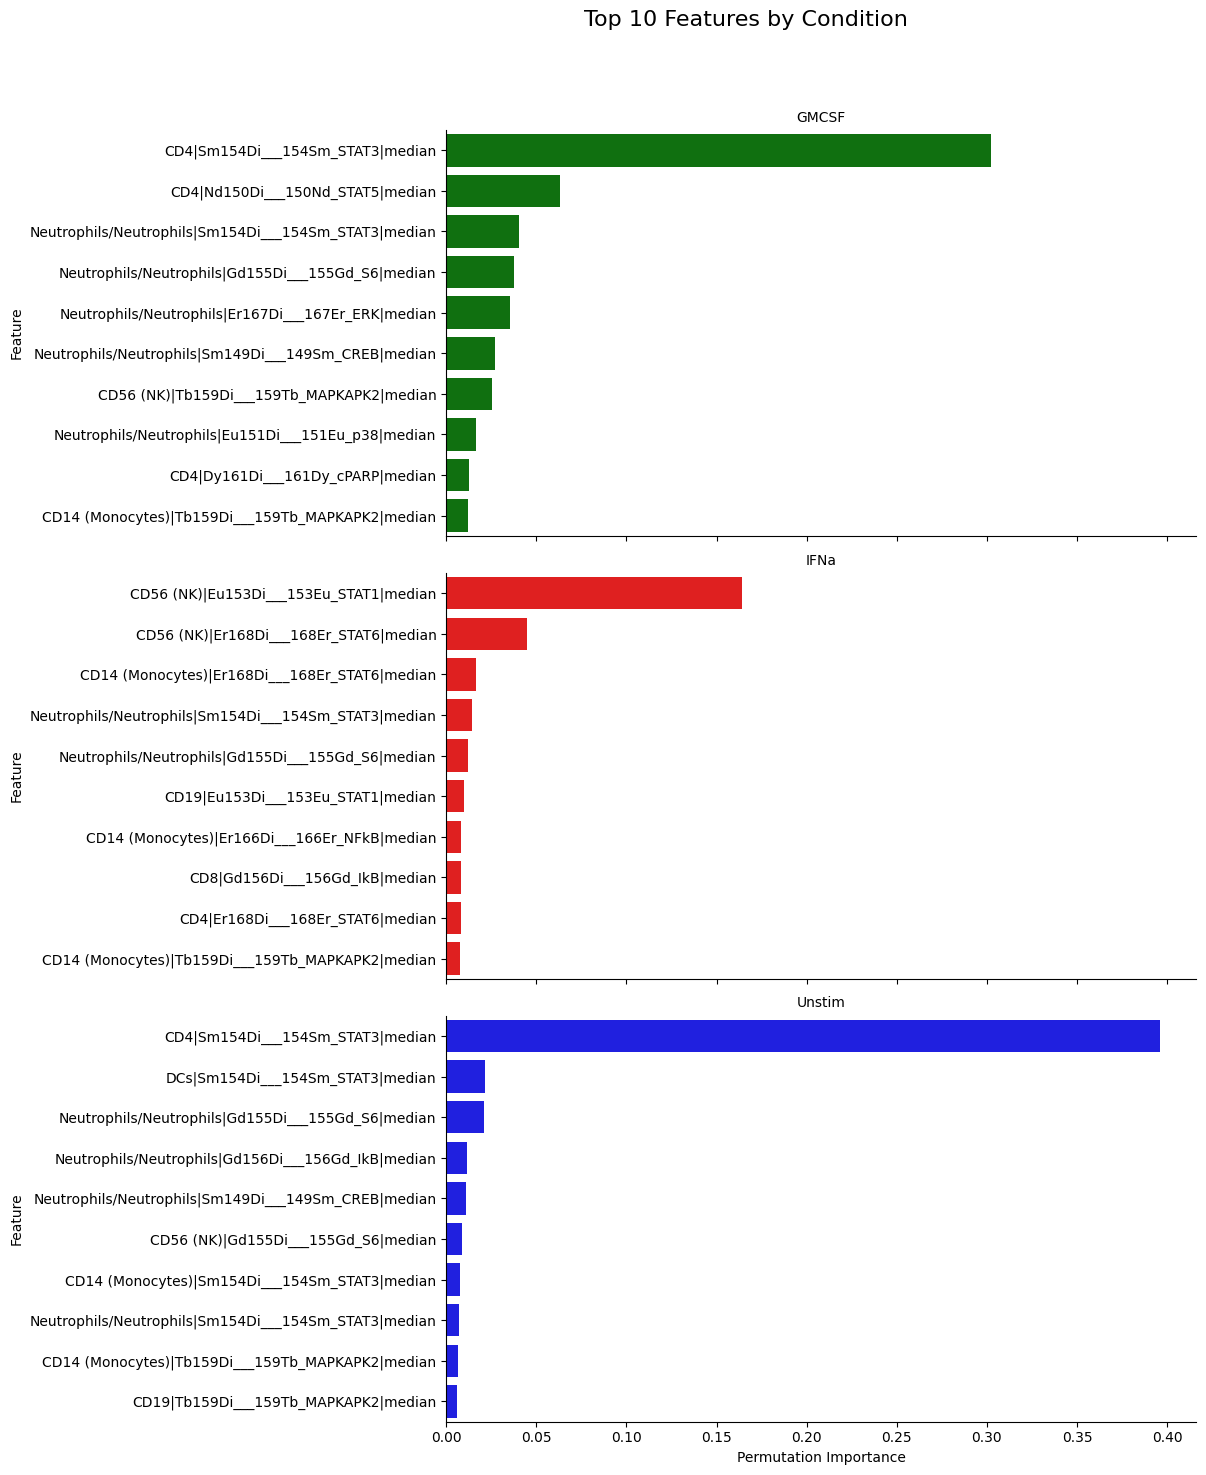

In [84]:
# Load data and label conditions
gmcsf = pd.read_csv('GMCSF_perm_importance.csv')
gmcsf["Condition"] = "GMCSF"

ifna = pd.read_csv('IFNa_perm_importance.csv')
ifna["Condition"] = "IFNa"

unstim = pd.read_csv('unstim_perm_importance.csv')
unstim["Condition"] = "Unstim"

# Combine all data
df = pd.concat([gmcsf, ifna, unstim])

# Select top 10 features for each condition
top_gmcsf = gmcsf.nlargest(10, 'Permutation Importance')
top_ifna = ifna.nlargest(10, 'Permutation Importance')
top_unstim = unstim.nlargest(10, 'Permutation Importance')

# Combine into one dataframe
top_features_df = pd.concat([top_gmcsf, top_ifna, top_unstim])

# Define the color palette for each condition
condition_palette = {
    'GMCSF': 'green',
    'IFNa': 'red',
    'Unstim': 'blue'
}

# Create FacetGrid
plt.figure(figsize=(20, 50))
g = sns.FacetGrid(top_features_df, col="Condition", height=5, col_wrap=1, sharey=False, aspect=2)

# Custom plotting function to sort features by importance
def plot_sorted_bars(data, **kwargs):
    condition = data['Condition'].iloc[0]
    color = condition_palette[condition]
    sorted_data = data.sort_values('Permutation Importance', ascending=False)
    ax = plt.gca()
    sns.barplot(x='Permutation Importance', y='Feature', data=sorted_data, 
                ax=ax, color=color)

# Map the custom plotting function
g.map_dataframe(plot_sorted_bars)

# Formatting
g.set_axis_labels("Permutation Importance", "Feature")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Features by Condition", fontsize=16)
g.fig.tight_layout()
g.fig.subplots_adjust(left=0.2, right=0.95, top=0.90)

plt.savefig("feature_importance_facet.png")
plt.show()